In [1]:
# Importing the libraries
import os
import copy
import contextlib
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import pytorch_forecasting
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, RMSE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.loggers import CSVLogger
import optuna
from optuna.integration import PyTorchLightningPruningCallback
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import logging
logging.getLogger("lightning.pytorch").setLevel(logging.WARNING)
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*Using default `ModelCheckpoint`.*")

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler 

os.environ["PL_TORCHVISION_BACKEND"] = "PIL"

## Loading and preparing the data

In [2]:
weather_bg = pd.read_csv('beograd_weather.csv')
weather_bg.columns = ['date', 'precipitation_sum', 'wind_direction', 'max_wind_gusts', 'dew_point', 'min_temperature', 'wind_speed', 
                   'relative_humidity', 'cloud_cover', 'shortwave_radiation_sum', 'pressure_msl', 'avg_temperature', 'max_temperature']
weather_bg['date'] = pd.to_datetime(weather_bg['date'])
weather_bg.head(3)

date  precipitation_sum  wind_direction  max_wind_gusts  dew_point  \
0 2022-01-01                0.4           256.0            30.6        5.9   
1 2022-01-02                0.0           197.0            21.2        5.7   
2 2022-01-03                0.0           237.0            22.7        4.3   

   min_temperature  wind_speed  relative_humidity  cloud_cover  \
0              3.9        12.2               88.0         62.0   
1              4.2         8.4               87.0         61.0   
2              3.5         9.5               83.0         95.0   

   shortwave_radiation_sum  pressure_msl  avg_temperature  max_temperature  
0                     5.90        1023.5              7.9             12.7  
1                     6.43        1024.7              7.8             13.6  
2                     5.63        1017.8              7.1             12.0

In [3]:
weather_lj = pd.read_csv('ljubljana_weather.csv')
weather_lj.columns = ['date', 'avg_temperature', 'dew_point', 'relative_humidity',  'pressure_msl', 'wind_direction', 'precipitation_sum', 
                      'wind_speed', 'cloud_cover','max_temperature', 'min_temperature', 'max_wind_gusts', 'shortwave_radiation_sum']
weather_lj['date'] = pd.to_datetime(weather_lj['date'])
weather_lj.head(3)

date  avg_temperature  dew_point  relative_humidity  pressure_msl  \
0 2022-01-01              0.9       -0.8               89.0        1026.6   
1 2022-01-02              2.7        0.2               84.0        1025.1   
2 2022-01-03              3.8        2.8               93.0        1019.8   

   wind_direction  precipitation_sum  wind_speed  cloud_cover  \
0           242.0                0.0         4.5         63.0   
1           229.0                0.0         5.1         52.0   
2           262.0                0.0         7.2         99.0   

   max_temperature  min_temperature  max_wind_gusts  shortwave_radiation_sum  
0              7.4             -3.8            15.5                     6.01  
1              9.8             -2.3            22.3                     6.27  
2              7.7              1.4            27.4                     2.99

In [4]:
def prepare_data(df, weather_df):
    df = df.copy()
    
    cols_to_drop = ['pm10', 'o3', 'no2', 'so2', 'co']
    cols_to_drop = [col for col in cols_to_drop if col in df.columns]
    df = df.drop(columns=cols_to_drop)
    
    df['date'] = pd.to_datetime(df['date'])
    df = df[df['date'] >= '2022-01-01']
    
    full_date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
    date_df = pd.DataFrame({'date': full_date_range})
    df = date_df.merge(df, on='date', how='left')

    # fill NaNs
    df['pm25'] = df['pm25'].ffill().bfill()

    # merge with weather data
    df = pd.merge(df, weather_df, on='date', how='inner')
    df = df.sort_values(by='date')
    
    df['time_idx'] = range(len(df))
    df["dummy_group"] = 0
    
    df['pm25'] = pd.to_numeric(df['pm25'], errors='coerce').astype('float32')
    df = df.iloc[:-1]
    df['pm25'] = df['pm25'].ffill().bfill()
    
    df['month'] = df['date'].dt.month.astype('str')
    df['day_of_week'] = df['date'].dt.dayofweek.astype(str)
    
    return df

In [5]:
df_bg = pd.read_csv('beograd_starigrad.csv')
df_bg = prepare_data(df_bg, weather_bg)
df_lj = pd.read_csv('ljubljana_bezigrad.csv')
df_lj = prepare_data(df_lj, weather_lj)

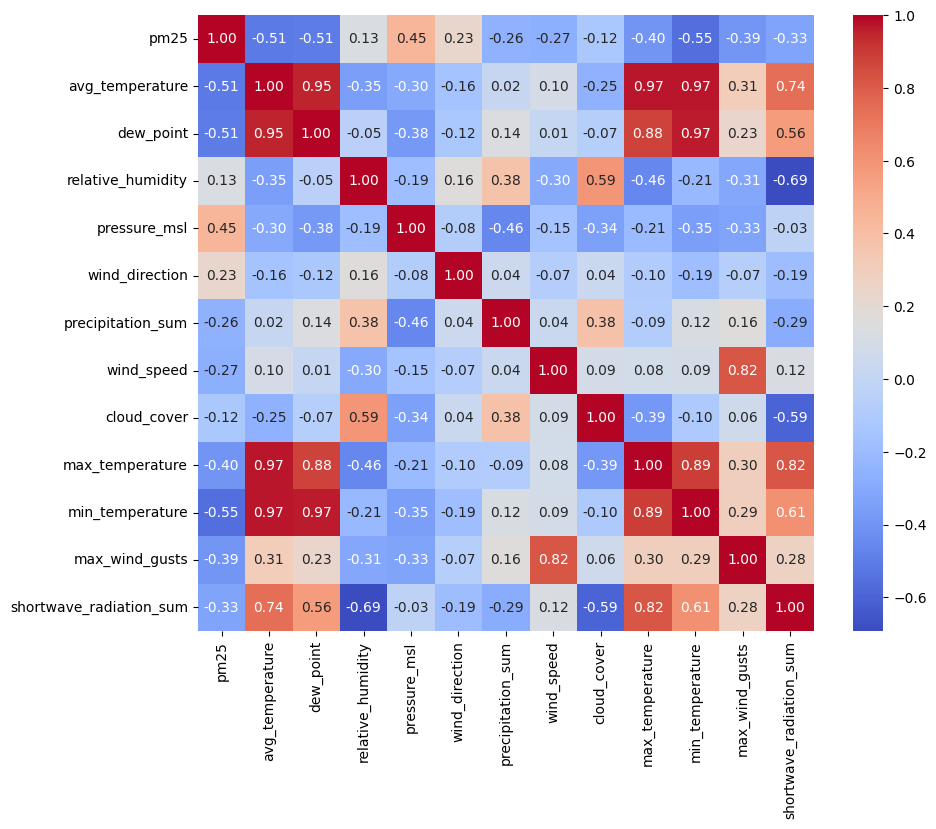

In [6]:
df = df_lj
train_df = df[df['date'].dt.year < 2025]
corr_matrix = train_df.drop(columns=['dummy_group', 'date', 'time_idx', 'month', 'day_of_week']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.show()

In [7]:
def add_lagged_features(df, lags=[1], features=["max_wind_gusts", "wind_speed", "pressure_msl", "relative_humidity", "precipitation_sum"]):
    df = df.copy()
    for feature in features:
        for lag in lags:
            lag_col = f"{feature}_lag{lag}"
            df[lag_col] = df[feature].shift(lag)
            df[lag_col] = df[lag_col].ffill().bfill()
    return df

In [8]:
def feature_engineering(df):
    # drop highly correlated features (>0.95)
    df = df.drop(columns=['avg_temperature', 'dew_point']) #dew point highly correlated with temperature min

    df["wind_direction_sin"] = np.sin(np.deg2rad(df["wind_direction"]))
    df["wind_direction_cos"] = np.cos(np.deg2rad(df["wind_direction"]))
    df = df.drop(columns=["wind_direction"])
    df['is_weekend'] = df['date'].dt.dayofweek.isin([5, 6]).astype(int)
    df = add_lagged_features(df, lags=[1], features=["max_wind_gusts", "wind_speed", "wind_direction_cos", "wind_direction_sin", "pressure_msl", 
                                                     "relative_humidity", "precipitation_sum", "min_temperature", "max_temperature", "cloud_cover"])
    return df

df_lj =  feature_engineering(df_lj)
df_bg =  feature_engineering(df_bg)

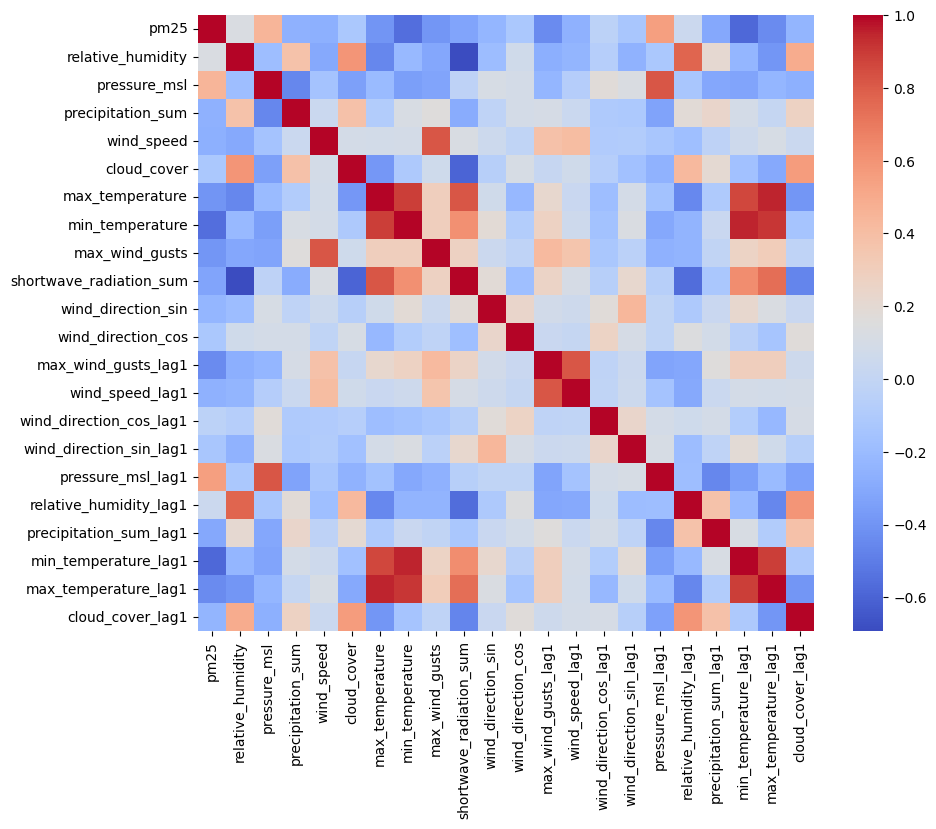

In [9]:
# choose which features to lag
df = df_lj
train_df = df[df['date'].dt.year < 2025]
train_df = add_lagged_features(train_df, lags=[1])
corr_matrix = train_df.drop(columns=['date', 'month', 'dummy_group', 'time_idx', 'day_of_week', 'is_weekend']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="coolwarm", square=True)
plt.show()

## Naive Baseline

In [10]:
def predict_last_week(df, start_idx=1128):
    test_df = df.copy()
    test_df = test_df[test_df['date'].dt.year == 2025]
    test_df = test_df[(test_df["time_idx"] >= start_idx) & (test_df["time_idx"] < 1236)]
    test_df['day_of_week'] = test_df['date'].dt.dayofweek  # Monday=0, Sunday=6

    # start from the first monday
    first_monday = test_df[test_df['day_of_week'] == 0]['date'].min()
    test_df = test_df[test_df['date'] >= first_monday]

    test_df['baseline_pred'] = test_df['pm25'].shift(7) 
    test_df = test_df.dropna(subset=['baseline_pred'])

    y_true = test_df['pm25']
    y_pred = test_df['baseline_pred']

    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    print("Baseline model overall performance:")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")

    # calculate 5-day window metrics
    window_size = 5
    results = []
    
    for i in range(0, len(test_df) - window_size + 1, window_size):
        window = test_df.iloc[i:i+window_size]
        y_true = window['pm25']
        y_pred = window['baseline_pred']
        
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        
        results.append({
            'start_date': window['date'].iloc[0],
            'end_date': window['date'].iloc[-1],
            'rmse': rmse,
            'mae': mae
        })
    results_df = pd.DataFrame(results)  
    print(results_df)
    return results_df

In [11]:
results_lj = predict_last_week(df_lj)
results_lj.drop(columns=['start_date', 'end_date']).describe()

Baseline model overall performance:
Test RMSE: 36.7977
Test MAE: 26.6300
   start_date   end_date       rmse        mae
0  2025-02-10 2025-02-14  53.633945  41.400002
1  2025-02-15 2025-02-19  77.230823  73.000000
2  2025-02-20 2025-02-24  57.015788  46.000000
3  2025-02-25 2025-03-01  69.522657  61.799999
4  2025-03-02 2025-03-06  33.879198  30.600000
5  2025-03-07 2025-03-11  33.102871  30.200001
6  2025-03-12 2025-03-16  55.425626  54.400002
7  2025-03-17 2025-03-21  29.230122  26.799999
8  2025-03-22 2025-03-26  11.549892   9.400000
9  2025-03-27 2025-03-31  18.926173  15.000000
10 2025-04-01 2025-04-05  17.899720  15.200000
11 2025-04-06 2025-04-10   9.633276   8.400000
12 2025-04-11 2025-04-15   9.979980   8.000000
13 2025-04-16 2025-04-20  27.589853  26.000000
14 2025-04-21 2025-04-25  11.224972   9.200000
15 2025-04-26 2025-04-30   8.282512   6.200000
16 2025-05-01 2025-05-05  29.529646  24.000000
17 2025-05-06 2025-05-10  26.593232  23.200001
18 2025-05-11 2025-05-15  16.81665

rmse        mae
count  20.000000  20.000000
mean   30.493269  26.630000
std    21.131930  19.464113
min     8.282512   6.200000
25%    12.486301  10.600000
50%    27.091543  23.600000
75%    38.817885  33.300001
max    77.230823  73.000000

In [12]:
results_bg = predict_last_week(df_bg)
results_bg.drop(columns=['start_date', 'end_date']).describe()

Baseline model overall performance:
Test RMSE: 31.6471
Test MAE: 22.5000
   start_date   end_date       rmse        mae
0  2025-02-10 2025-02-14  33.615473  26.400000
1  2025-02-15 2025-02-19  11.099549  10.000000
2  2025-02-20 2025-02-24  38.212563  33.000000
3  2025-02-25 2025-03-01  34.891260  26.600000
4  2025-03-02 2025-03-06  38.507143  36.000000
5  2025-03-07 2025-03-11  36.207734  28.600000
6  2025-03-12 2025-03-16  72.821700  61.799999
7  2025-03-17 2025-03-21  50.972541  40.599998
8  2025-03-22 2025-03-26  22.622997  18.600000
9  2025-03-27 2025-03-31  39.230090  33.400002
10 2025-04-01 2025-04-05  24.211568  16.600000
11 2025-04-06 2025-04-10  22.702423  15.400000
12 2025-04-11 2025-04-15  18.724316  15.800000
13 2025-04-16 2025-04-20  16.291102  12.200000
14 2025-04-21 2025-04-25  23.693882  18.200001
15 2025-04-26 2025-04-30  19.969977  16.000000
16 2025-05-01 2025-05-05   8.402381   7.400000
17 2025-05-06 2025-05-10   7.536577   6.000000
18 2025-05-11 2025-05-15   8.78635

rmse        mae
count  20.000000  20.000000
mean   27.511029  22.500000
std    16.048718  13.689566
min     7.536577   6.000000
25%    18.116012  14.600000
50%    23.198152  18.400001
75%    36.708941  29.700000
max    72.821700  61.799999

## Define dataset and dataloaders

In [13]:
df_lj["group"] = "ljubljana"
df_bg["group"] = "beograd"

df = pd.concat([df_lj, df_bg], axis=0)
df = df.drop(columns=['dummy_group']).reset_index(drop=True)
df.head(3)

date   pm25  relative_humidity  pressure_msl  precipitation_sum  \
0 2022-01-01  129.0               89.0        1026.6                0.0   
1 2022-01-02  129.0               84.0        1025.1                0.0   
2 2022-01-03   91.0               93.0        1019.8                0.0   

   wind_speed  cloud_cover  max_temperature  min_temperature  max_wind_gusts  \
0         4.5         63.0              7.4             -3.8            15.5   
1         5.1         52.0              9.8             -2.3            22.3   
2         7.2         99.0              7.7              1.4            27.4   

   ...  wind_speed_lag1  wind_direction_cos_lag1 wind_direction_sin_lag1  \
0  ...              4.5                -0.469472               -0.882948   
1  ...              4.5                -0.469472               -0.882948   
2  ...              5.1                -0.656059               -0.754710   

  pressure_msl_lag1  relative_humidity_lag1  precipitation_sum_lag1  \
0            1026.6                    89.0                     0.0   
1            1026.6                    89.0                     0.0   
2            1025.1                    84.0                     0.0   

   min_temperature_lag1  max_temperature_lag1  cloud_cover_lag1      group  
0                  -3.8                   7.4              63.0  ljubljana  
1                  -3.8                   7.4              63.0  ljubljana  
2                  -2.3                   9.8              52.0  ljubljana  

[3 rows x 28 columns]

In [14]:
max_encoder_length = 60 
max_prediction_length = 5 

# Split training and testing data
df = df[df["date"] <= "2025-05-20"].copy()
df = df.sort_values('date').reset_index(drop=True)
test_size = 2 * (20 * 5 + max_encoder_length)
test_df = df.iloc[-test_size:]   
test_df.loc[:, 'is_weekend'] = test_df['is_weekend'].astype(str)
train_val_df = df.iloc[:-200].copy()
train_val_df.loc[:, 'is_weekend'] = train_val_df['is_weekend'].astype(str)
val_size = 2 * (10 * 5 + max_encoder_length)
val_df = train_val_df.iloc[-val_size:]
train_df = train_val_df.iloc[:-100]

In [203]:
belgrade_df = test_df[test_df['group'] == 'beograd']
ljubljana_df = test_df[test_df['group'] == 'ljubljana']
belgrade_mean = belgrade_df['pm25'].mean()
belgrade_std = belgrade_df['pm25'].std()
ljubljana_mean = ljubljana_df['pm25'].mean()
ljubljana_std = ljubljana_df['pm25'].std()
print("Belgrade TEST - Mean:", belgrade_mean, "Std:", belgrade_std)
print("Ljubljana TEST - Mean:", ljubljana_mean, "Std:", ljubljana_std)

Belgrade TEST - Mean: 79.69375 Std: 34.79265
Ljubljana TEST - Mean: 57.475 Std: 34.909218


In [204]:
lagged_features = ["max_wind_gusts_lag1", "wind_speed_lag1", "wind_direction_sin_lag1", "wind_direction_cos_lag1", "pressure_msl_lag1", 
                   "relative_humidity_lag1", "precipitation_sum_lag1", "min_temperature_lag1", "max_temperature_lag1"]

training = TimeSeriesDataSet(
        train_df,
        time_idx="time_idx",
        target="pm25",  
        group_ids=["group"],  
        min_encoder_length=max_encoder_length//2,
        max_encoder_length=max_encoder_length,
        min_prediction_length=max_prediction_length,
        max_prediction_length=max_prediction_length,
        static_categoricals=["group"],
        time_varying_known_reals=["time_idx", "precipitation_sum", "relative_humidity", "min_temperature", "max_temperature", "pressure_msl", 
                                  "wind_speed", "max_wind_gusts", "cloud_cover", "shortwave_radiation_sum", "wind_direction_cos", "wind_direction_sin",
                                  "max_wind_gusts_lag1", "wind_speed_lag1", "wind_direction_sin_lag1", "wind_direction_cos_lag1", "pressure_msl_lag1", 
                                  "relative_humidity_lag1", "precipitation_sum_lag1", "min_temperature_lag1", "max_temperature_lag1"],
        time_varying_known_categoricals=["is_weekend", "month"], 
        time_varying_unknown_reals=["pm25"],
        target_normalizer=GroupNormalizer(groups=["group"], transformation="softplus"),
        lags={"pm25": [1]},
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )

validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)

## Hyperparameter tuning

In [18]:
def objective(trial):
    # suggest hyperparameters
    hidden_size = trial.suggest_categorical("hidden_size", [8, 16, 32, 64, 128])
    dropout = trial.suggest_float("dropout", 0.1, 0.3)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True)
    attention_head_size = trial.suggest_categorical("attention_head_size", [1, 2, 4])
    hidden_continuous_size = trial.suggest_categorical("hidden_continuous_size", [4, 8, 16, 32])

    # create dataloaders
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=10*batch_size, num_workers=0)

    # initialize TFT model
    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=learning_rate,
        hidden_size=hidden_size,
        attention_head_size=attention_head_size,
        dropout=dropout,
        hidden_continuous_size=hidden_continuous_size,
        loss=QuantileLoss(),
        log_interval=10,
        reduce_on_plateau_patience=3,
    )

    # set up trainer with pruning
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=8, verbose=False, mode="min")
    trainer = pl.Trainer(
        max_epochs=100,
        enable_model_summary=True,
        gradient_clip_val=0.1,
        log_every_n_steps=5,
        callbacks=[early_stop_callback, PyTorchLightningPruningCallback(trial, monitor="val_loss")],
    )

    # fit model
    trainer.fit(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )
    return trainer.callback_metrics["val_loss"].item()

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=15, timeout=3600*3)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key} = {value}")

[I 2025-05-31 02:23:54,411] A new study created in memory with name: no-name-3d6e5c26-29e4-44cf-a81c-0ec9f2e304a0
C:\Users\Korisnik\anaconda3\envs\tft_env\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\Korisnik\anaconda3\envs\tft_env\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

[I 2025-05-31 02:40:56,937] Trial 0 finished with value: 10.039064407348633 and parameters: {'hidden_size': 128, 'dropout': 0.10091228553670491, 'learning_rate': 0.0012052434337093145, 'attention_head_size': 1, 'hidden_continuous_size': 16, 'batch_size': 32}. Best is trial 0 with value: 10.039064407348633.


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

[I 2025-05-31 02:57:51,594] Trial 1 finished with value: 9.037335395812988 and parameters: {'hidden_size': 16, 'dropout': 0.14383413700388886, 'learning_rate': 0.0004979940806393934, 'attention_head_size': 1, 'hidden_continuous_size': 8, 'batch_size': 32}. Best is trial 1 with value: 9.037335395812988.


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

[I 2025-05-31 03:04:52,300] Trial 2 finished with value: 8.477860450744629 and parameters: {'hidden_size': 32, 'dropout': 0.20455259454312963, 'learning_rate': 0.01564793582710865, 'attention_head_size': 4, 'hidden_continuous_size': 4, 'batch_size': 64}. Best is trial 2 with value: 8.477860450744629.


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

[I 2025-05-31 03:23:47,080] Trial 3 finished with value: 9.211727142333984 and parameters: {'hidden_size': 16, 'dropout': 0.18633846442255117, 'learning_rate': 0.0003261565384139961, 'attention_head_size': 2, 'hidden_continuous_size': 4, 'batch_size': 64}. Best is trial 2 with value: 8.477860450744629.


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

[I 2025-05-31 03:44:44,874] Trial 4 finished with value: 8.723779678344727 and parameters: {'hidden_size': 16, 'dropout': 0.1316320738050946, 'learning_rate': 0.00014427498086721173, 'attention_head_size': 1, 'hidden_continuous_size': 4, 'batch_size': 32}. Best is trial 2 with value: 8.477860450744629.


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

[I 2025-05-31 03:44:54,986] Trial 5 pruned. Trial was pruned at epoch 0.


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

[I 2025-05-31 03:45:07,656] Trial 6 pruned. Trial was pruned at epoch 0.


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

[I 2025-05-31 03:52:23,816] Trial 7 finished with value: 9.280070304870605 and parameters: {'hidden_size': 16, 'dropout': 0.14213356198208146, 'learning_rate': 0.0020744429085858213, 'attention_head_size': 1, 'hidden_continuous_size': 4, 'batch_size': 32}. Best is trial 2 with value: 8.477860450744629.


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

[I 2025-05-31 03:53:14,998] Trial 8 pruned. Trial was pruned at epoch 0.


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

[I 2025-05-31 03:53:32,338] Trial 9 pruned. Trial was pruned at epoch 0.


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

[I 2025-05-31 03:56:14,093] Trial 10 pruned. Trial was pruned at epoch 9.


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

[I 2025-05-31 03:57:32,709] Trial 11 pruned. Trial was pruned at epoch 4.


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

[I 2025-05-31 04:04:22,570] Trial 12 finished with value: 8.966809272766113 and parameters: {'hidden_size': 32, 'dropout': 0.22757780557515472, 'learning_rate': 0.00782737137571745, 'attention_head_size': 4, 'hidden_continuous_size': 4, 'batch_size': 32}. Best is trial 2 with value: 8.477860450744629.


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

[I 2025-05-31 04:04:44,698] Trial 13 pruned. Trial was pruned at epoch 0.


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

[I 2025-05-31 04:06:14,256] Trial 14 pruned. Trial was pruned at epoch 9.


Best trial:
  Value: 8.477860450744629
  Params: 
    hidden_size = 32
    dropout = 0.20455259454312963
    learning_rate = 0.01564793582710865
    attention_head_size = 4
    hidden_continuous_size = 4
    batch_size = 64


## Train Final TFT model

In [19]:
# PARAMETERS
hidden_size = 32
dropout = 0.20455259454312963
learning_rate = 0.01564793582710865
attention_head_size = 4
hidden_continuous_size = 4
batch_size = 64

In [20]:
# Dataloaders
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size)
val_dataloader = validation.to_dataloader(train=False, batch_size=10*batch_size)

# Initialize TFT model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=learning_rate,
    hidden_size=hidden_size,
    attention_head_size=attention_head_size,
    dropout=dropout,
    hidden_continuous_size=hidden_continuous_size,
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=3,
)

# Set up trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=8, verbose=False, mode="min")
checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min",  save_top_k=1, filename="best-{epoch:02d}-{val_loss:.4f}")
pl.seed_everything(89)
trainer = pl.Trainer(
    max_epochs=100,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    log_every_n_steps=10,
    callbacks=[checkpoint_callback, early_stop_callback],
)

Seed set to 89


In [21]:
# Fit model
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
print('RMSE on validation set:', RMSE()(predictions.output, predictions.y))
print('MAE on validation set:', MAE()(predictions.output, predictions.y))

Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

C:\Users\Korisnik\Desktop\FAKS\AI\lightning_logs\version_432\checkpoints\best-epoch=17-val_loss=8.1105.ckpt


C:\Users\Korisnik\anaconda3\envs\tft_env\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\Korisnik\anaconda3\envs\tft_env\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


RMSE on validation set: tensor(18.3382)
MAE on validation set: tensor(12.6367)


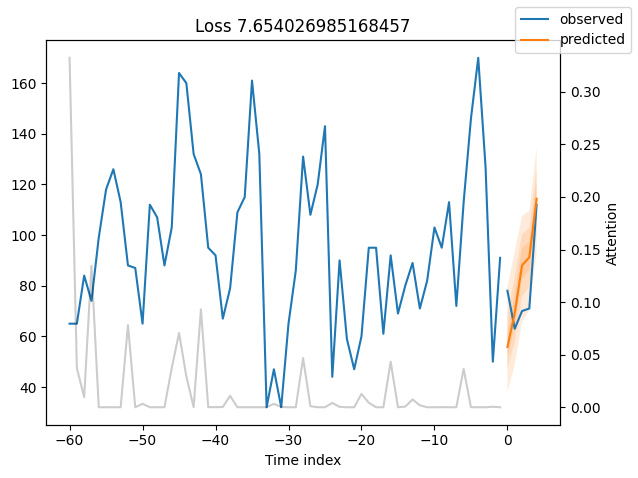

In [205]:
# Plot predictions on validation set
raw_prediction = best_tft.predict(val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu"))
fig = best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0, add_loss_to_title=True)
plt.show()

In [206]:
#raw_prediction = best_tft.predict(val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu"))
#for idx in range(0, 200):
#    fig = best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=idx, add_loss_to_title=False)
#    fig.savefig(f'series/prediction_val_plot_{idx}.png', dpi=300, bbox_inches='tight')
#    plt.show()

## Prediction vs actual on validation set by variable

In [31]:
predictions = best_tft.predict(val_dataloader, return_x=True, trainer_kwargs=dict(accelerator="cpu"))
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
# remove all lagged target variables
import copy
filtered_results = copy.deepcopy(predictions_vs_actuals)
for key in ['prediction', 'actual', 'support']:
    if key in filtered_results:
        filtered_results[key] = {
            k: v for k, v in filtered_results[key].items()
            if not k.startswith('pm25_lagged_by_')
        }

os.makedirs("val_avg_plots", exist_ok=True)
plt.ioff()

best_tft.plot_prediction_actual_by_variable(filtered_results)

for i, fig in enumerate(plt.get_fignums()):
    plt.figure(fig).savefig(f"val_avg_plots/variable_{i}.png")
    plt.close(fig)

plt.ion()

C:\Users\Korisnik\anaconda3\envs\tft_env\Lib\site-packages\pytorch_forecasting\models\base_model.py:2221: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(**kwargs)


C:\Users\Korisnik\anaconda3\envs\tft_env\Lib\site-packages\pytorch_forecasting\models\base_model.py:2221: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(**kwargs)


{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'pm25_center': <Figure size 1000x500 with 2 Axes>,
 'pm25_scale': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'precipitation_sum': <Figure size 1000x500 with 2 Axes>,
 'relative_humidity': <Figure size 1000x500 with 2 Axes>,
 'min_temperature': <Figure size 1000x500 with 2 Axes>,
 'max_temperature': <Figure size 1000x500 with 2 Axes>,
 'pressure_msl': <Figure size 1000x500 with 2 Axes>,
 'wind_speed': <Figure size 1000x500 with 2 Axes>,
 'max_wind_gusts': <Figure size 1000x500 with 2 Axes>,
 'cloud_cover': <Figure size 1000x500 with 2 Axes>,
 'shortwave_radiation_sum': <Figure size 1000x500 with 2 Axes>,
 'wind_direction_cos': <Figure size 1000x500 with 2 Axes>,
 'wind_direction_sin': <Figure size 1000x500 with 2 Axes>,
 'max_wind_gusts_lag1': <Figure size 1000x500 with 2 Axes>,
 'wind_speed_lag1': <Figure size 1000x500 with 2 Axes>,
 'wind_direction_sin_lag1': <Figure size 1000x500 with 2

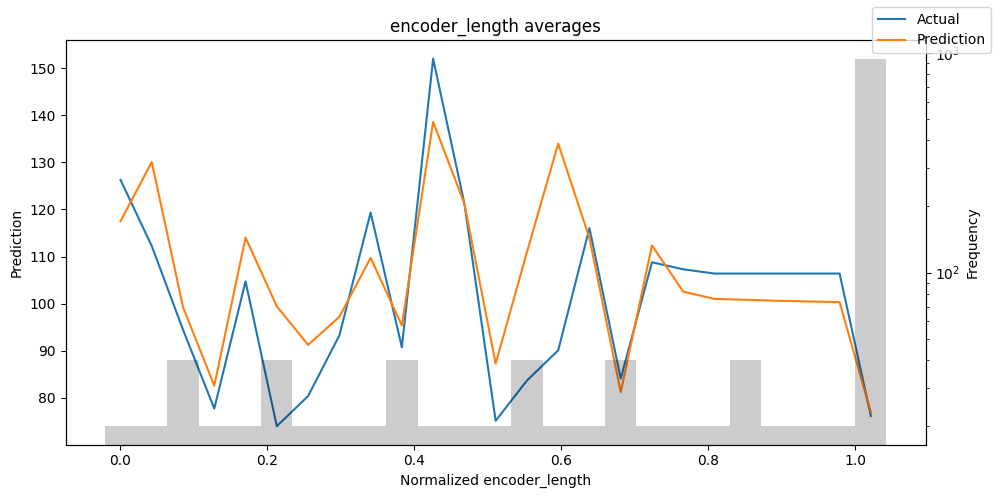

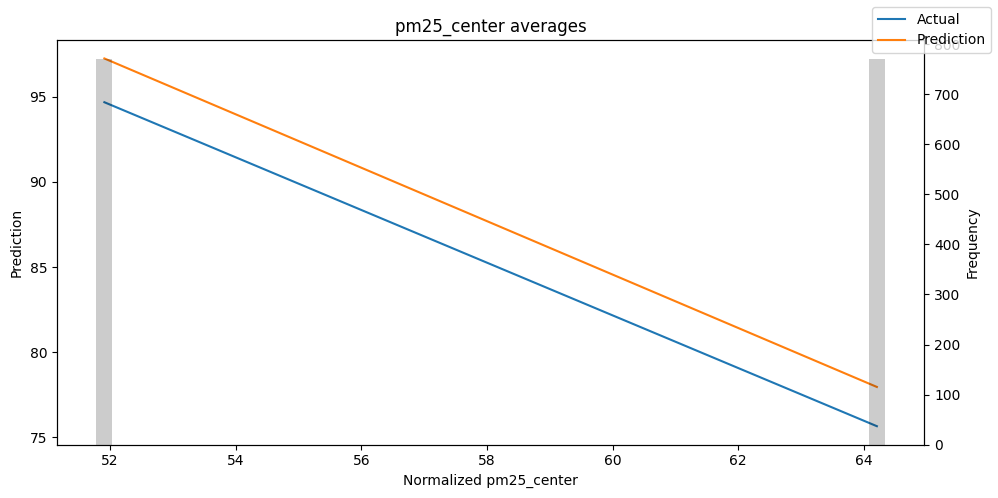

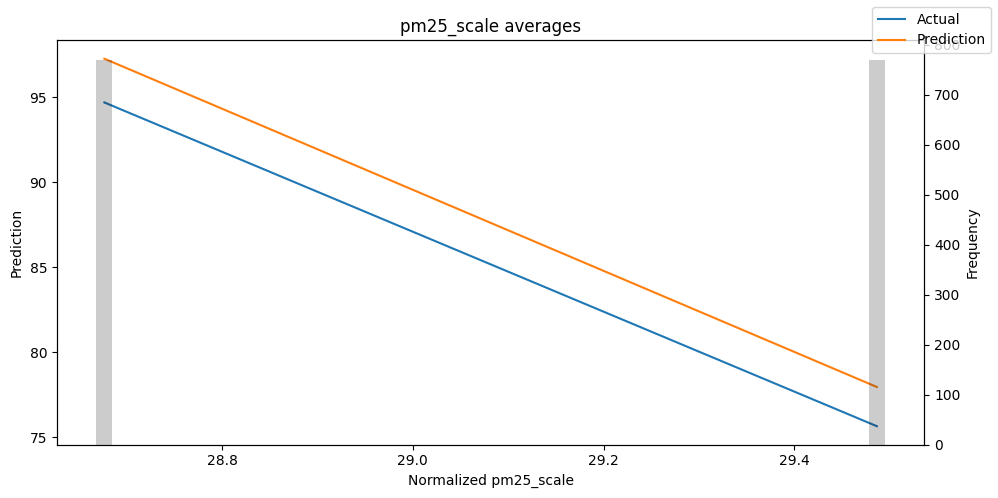

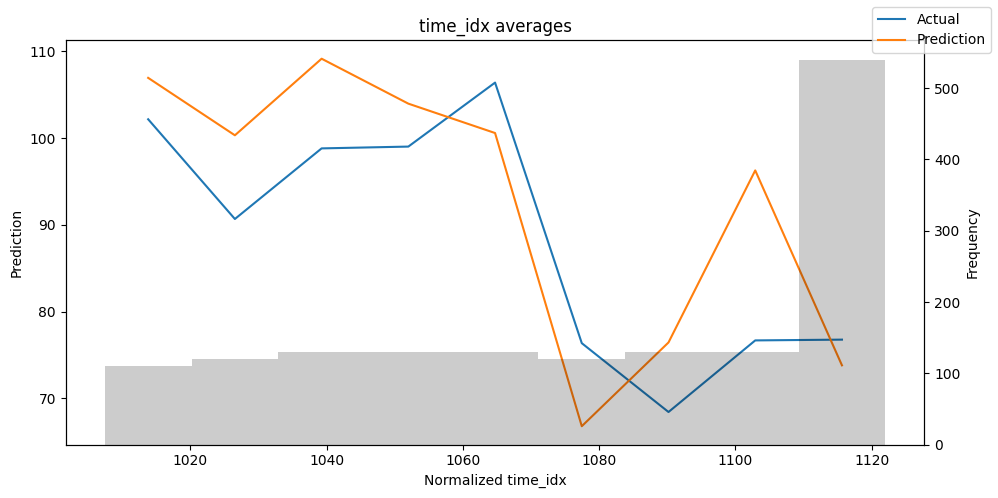

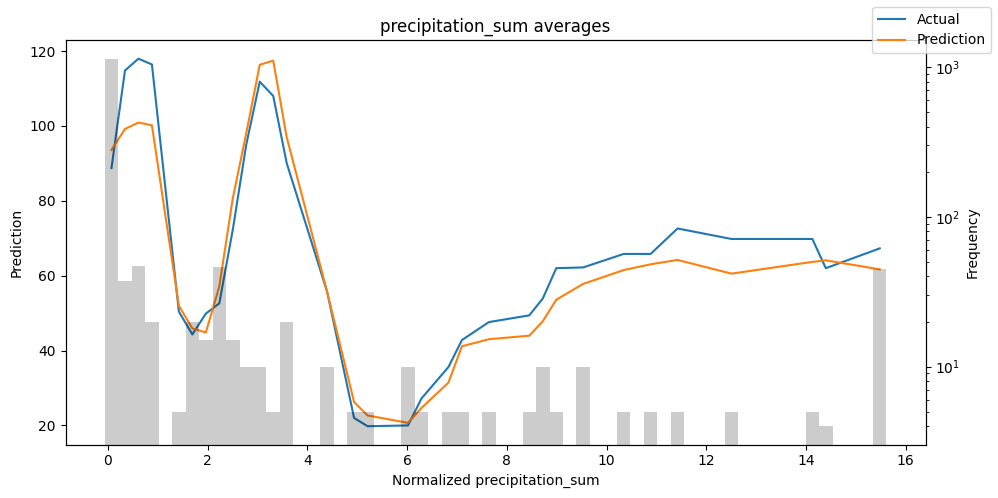

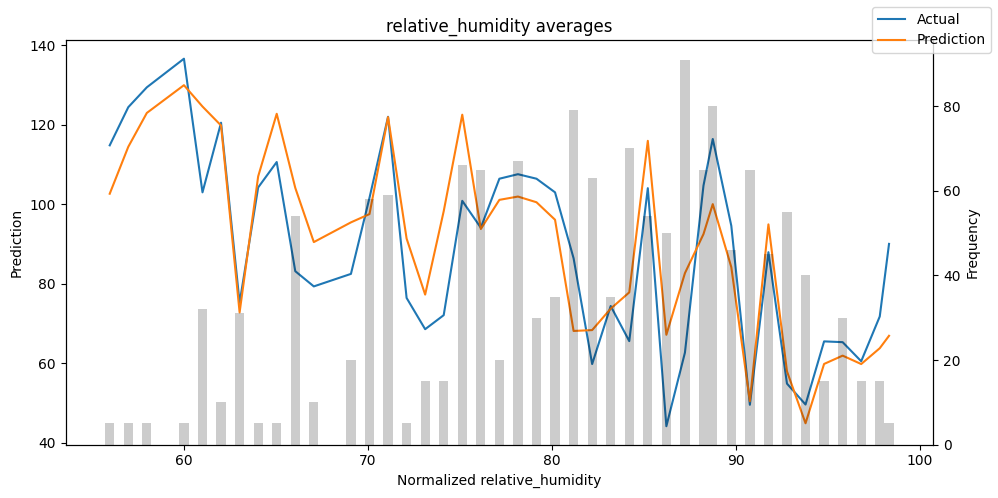

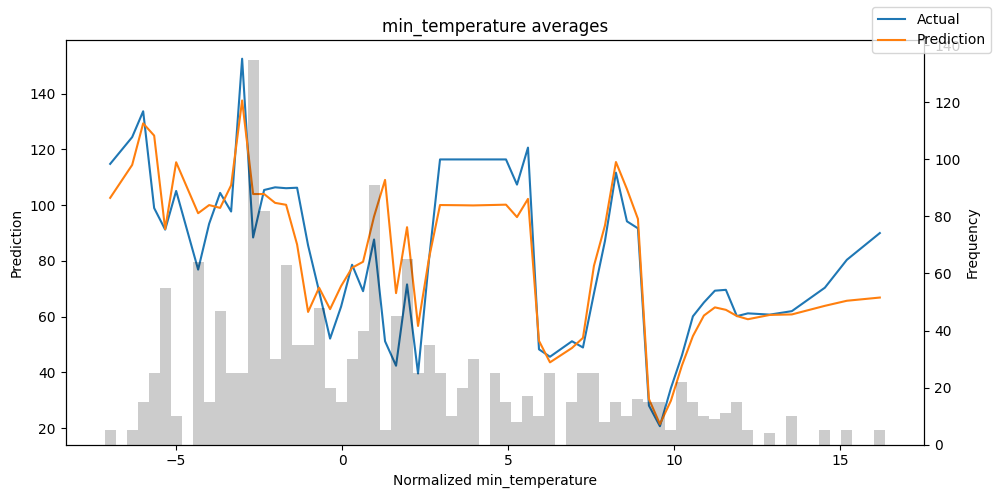

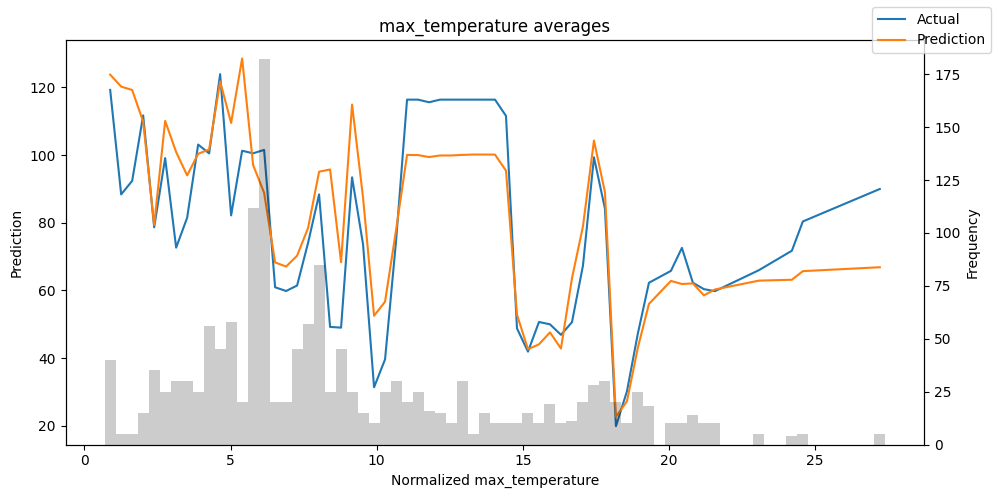

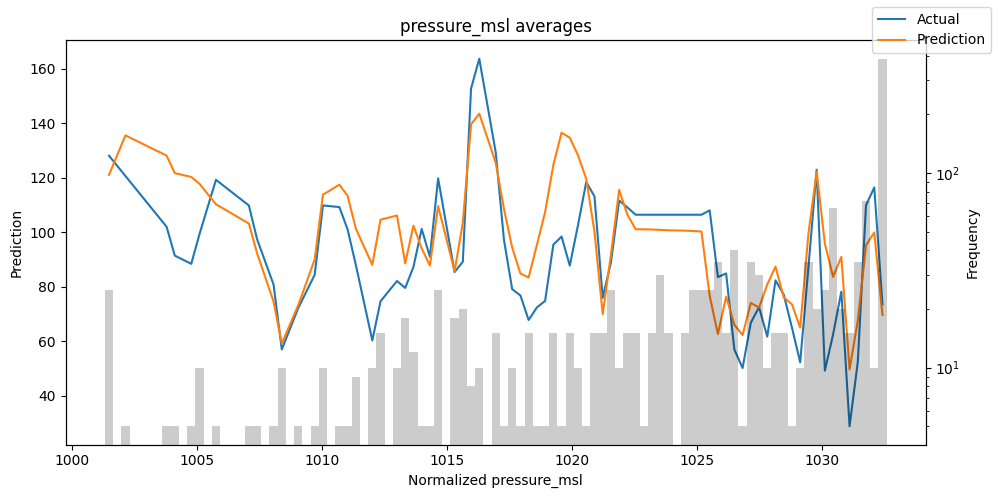

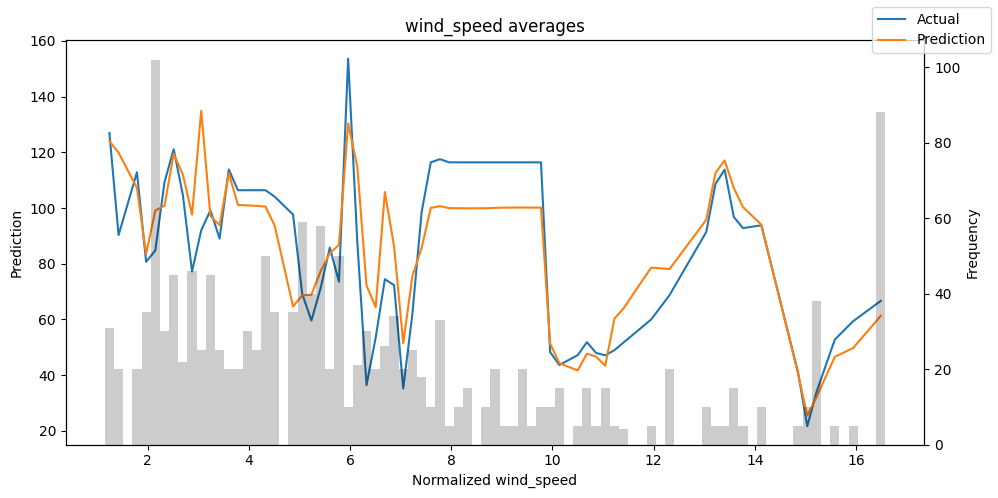

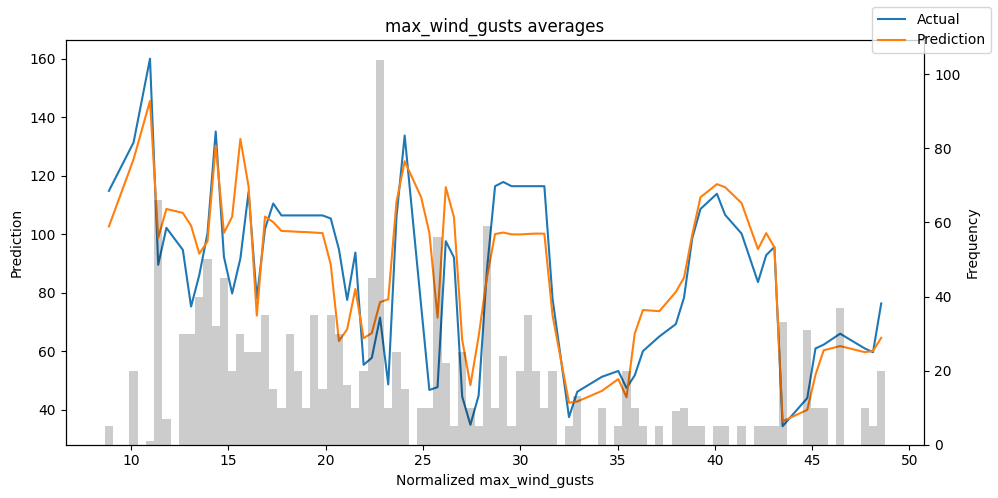

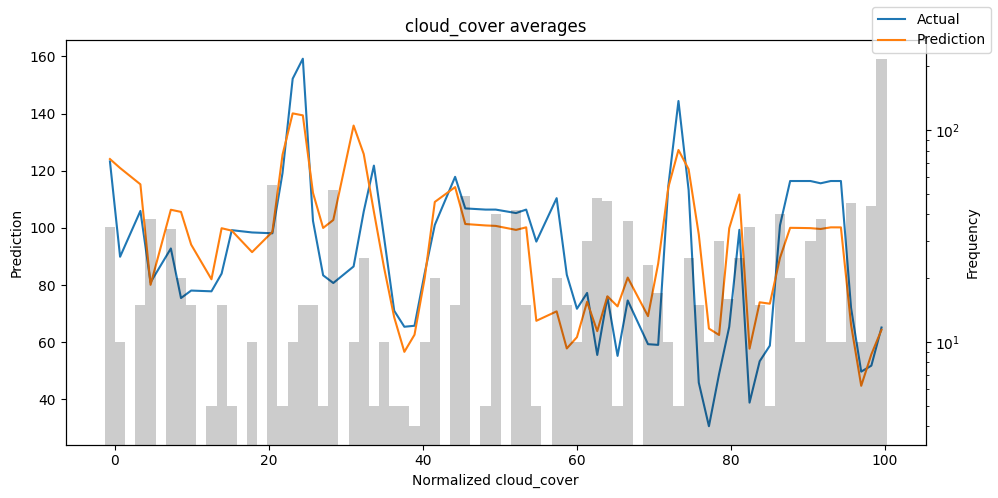

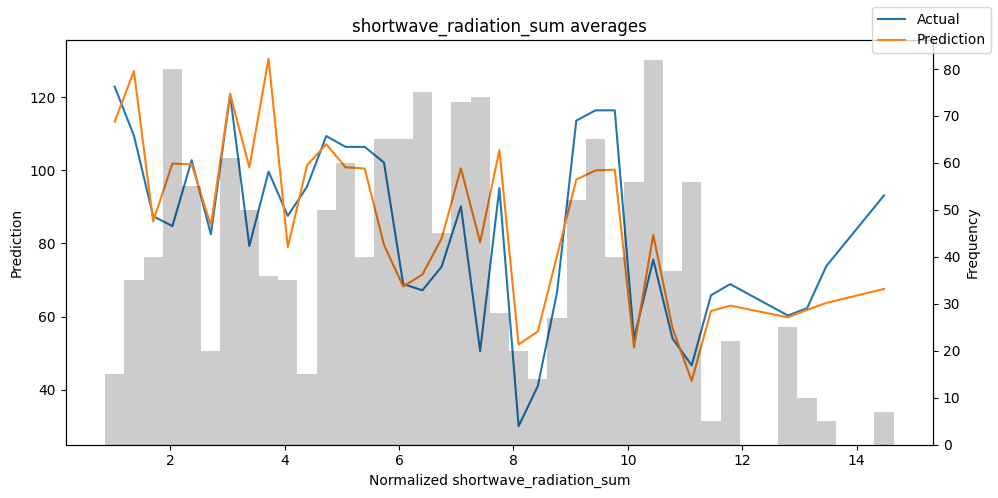

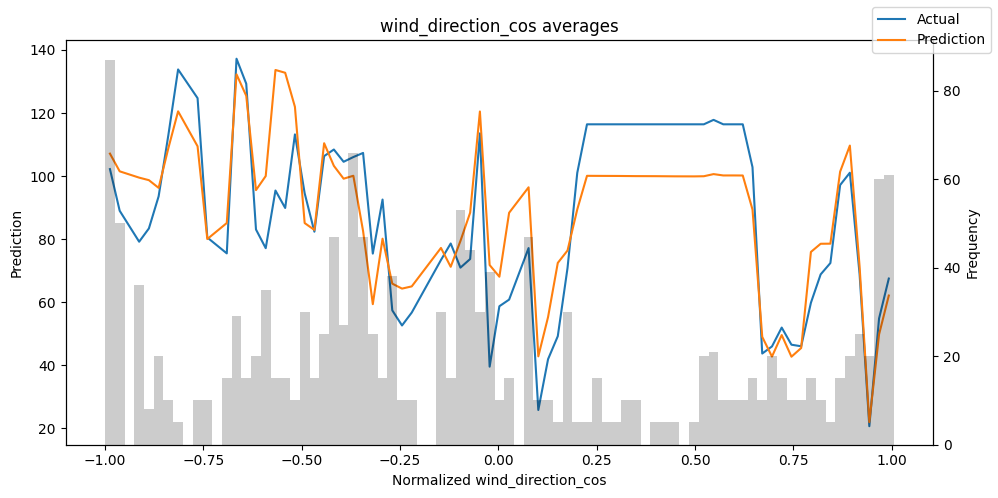

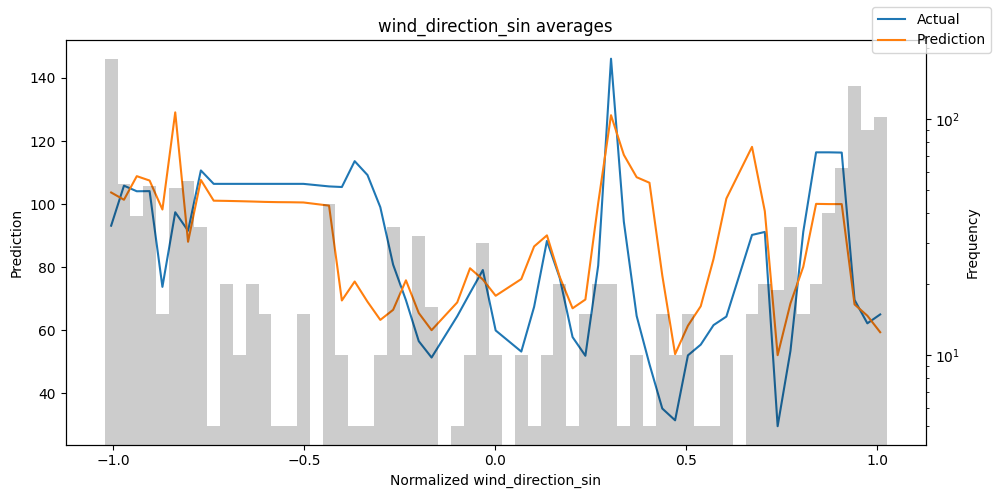

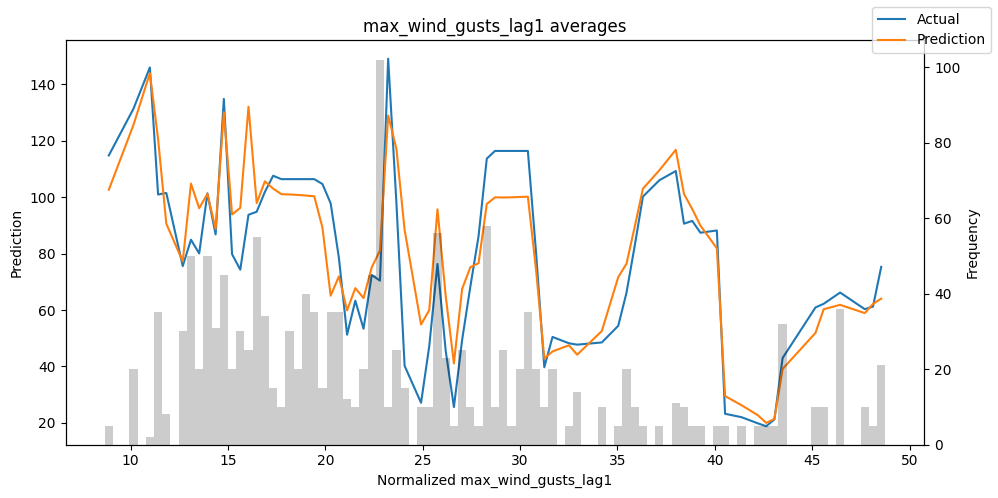

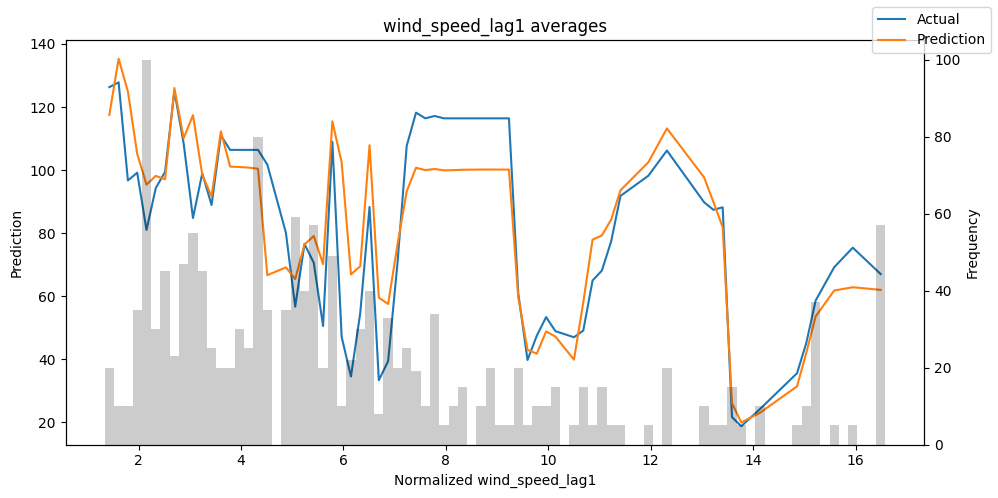

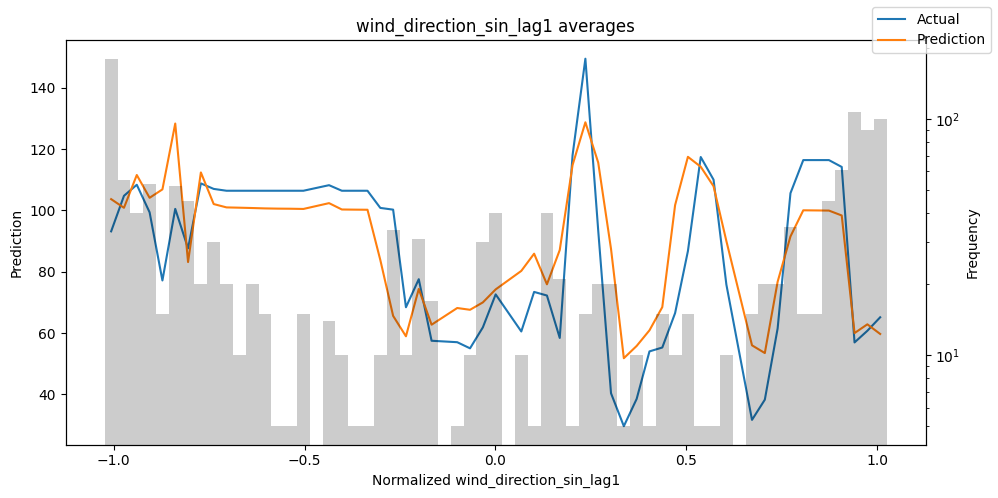

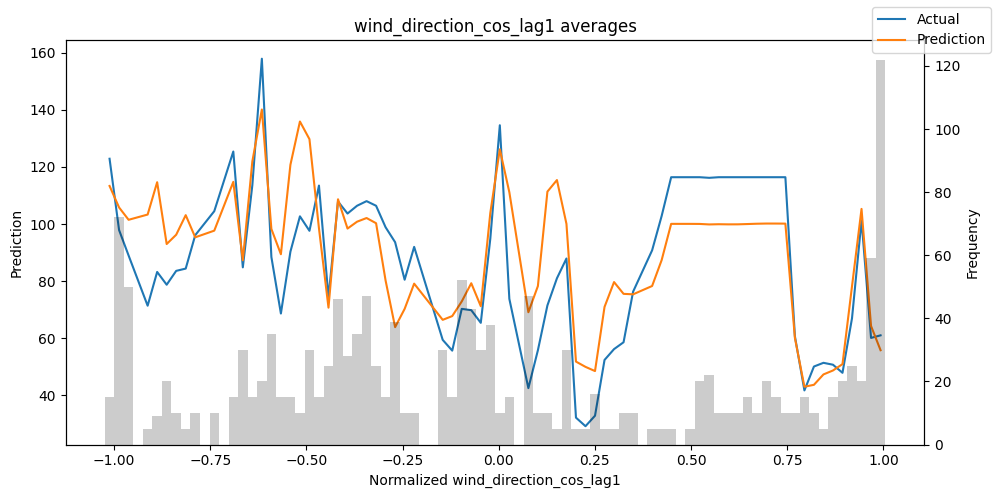

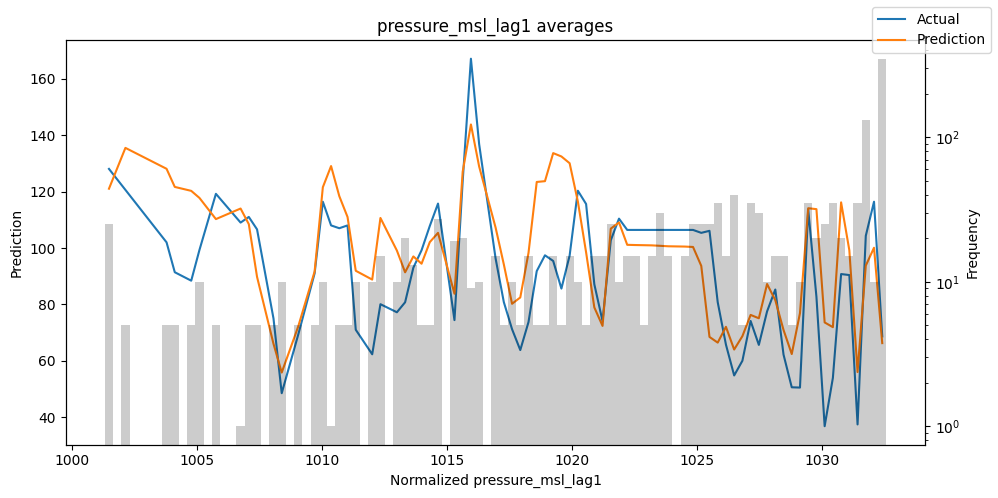

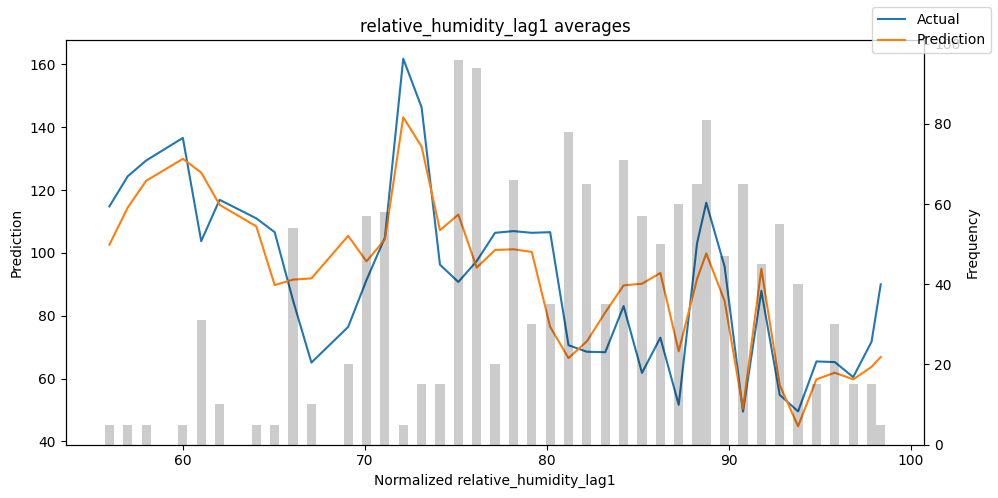

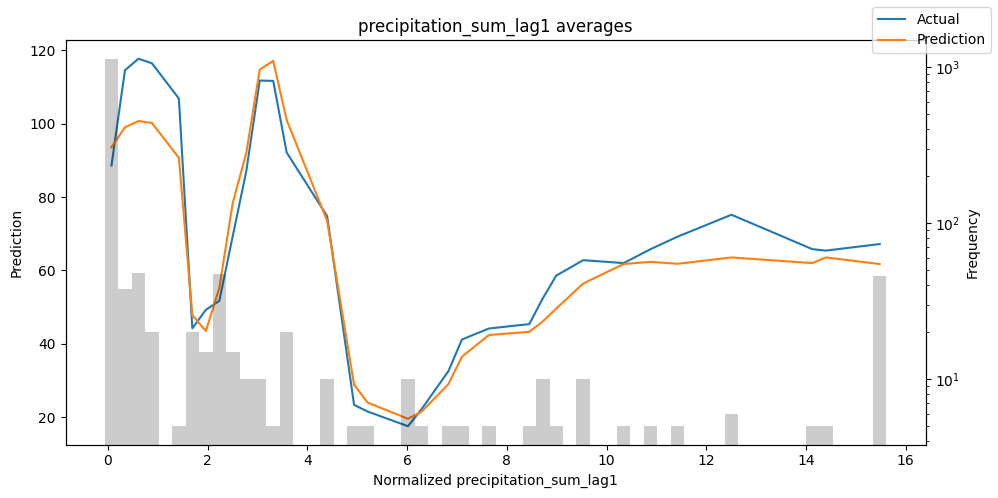

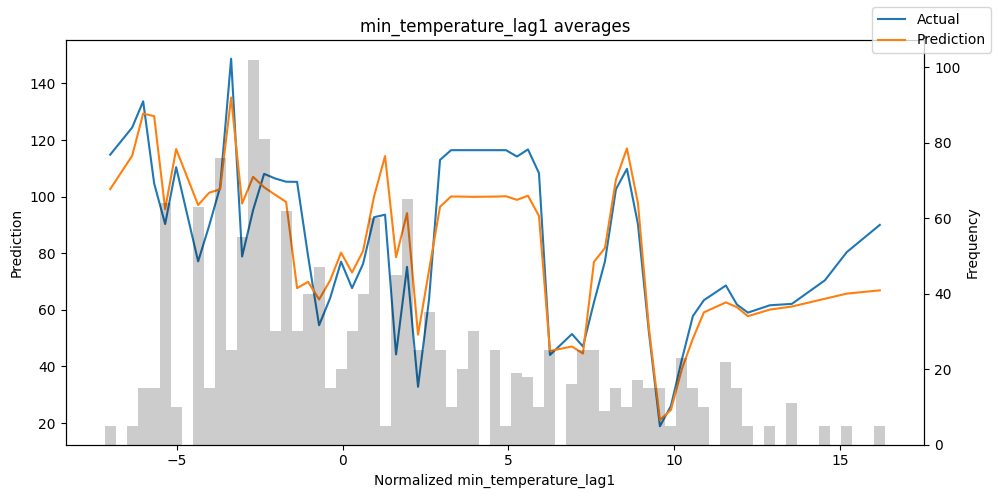

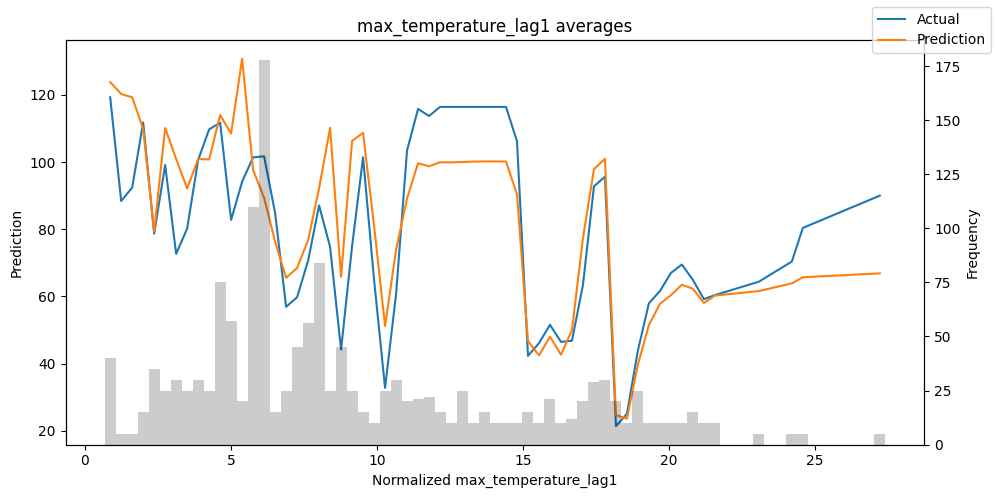

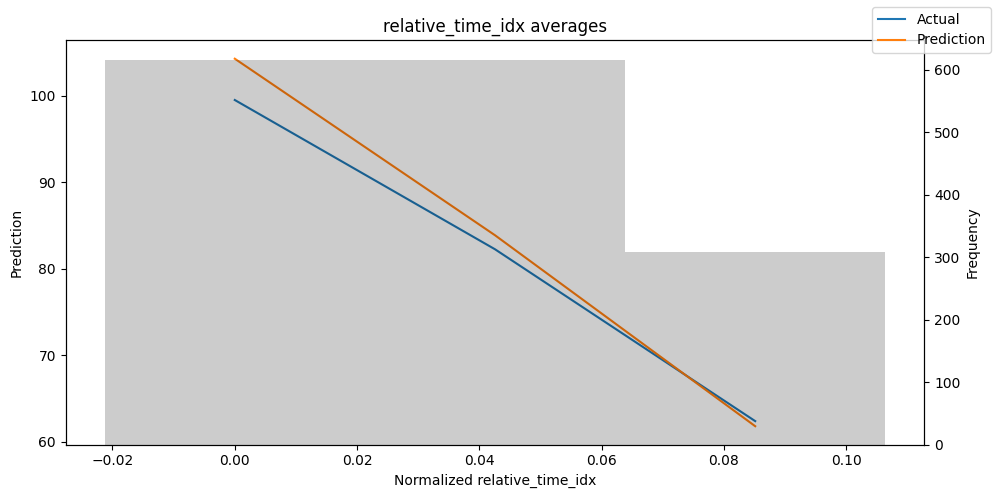

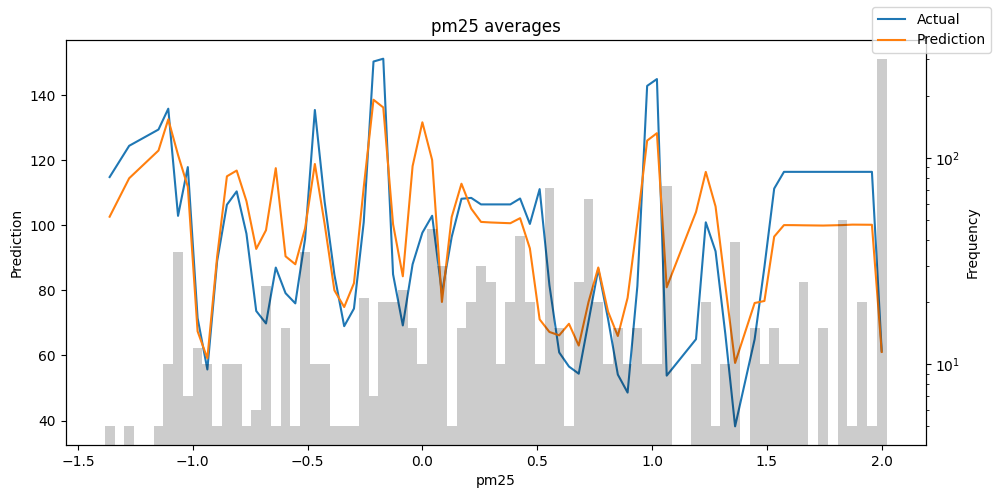

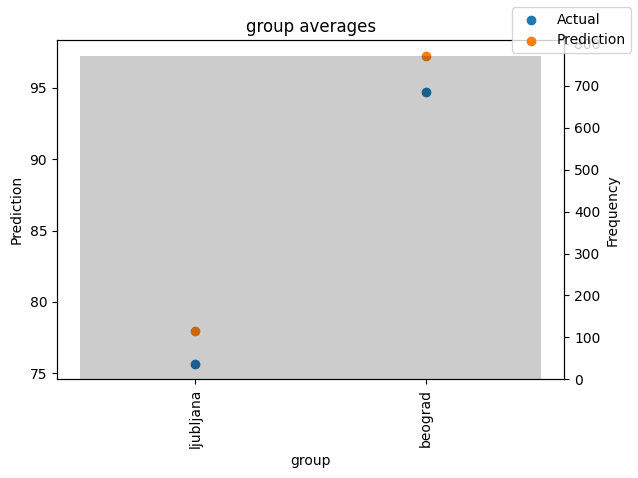

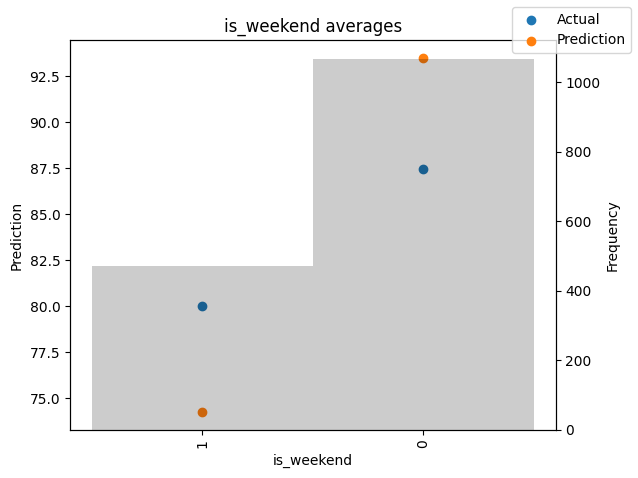

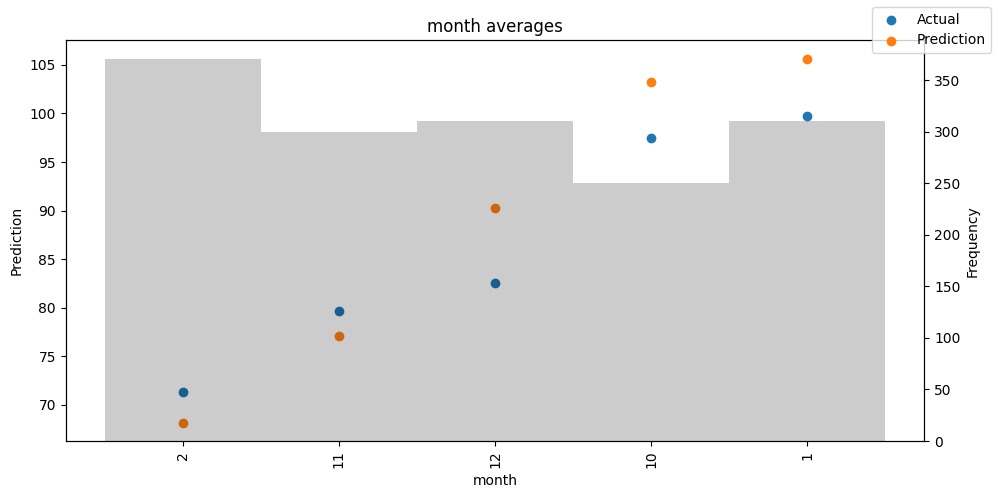

In [36]:
best_tft.plot_prediction_actual_by_variable(filtered_results)

## Evaluating TFT

In [34]:
def evaluate_forecasting_windows(model, training_dataset, test_df, lookback_window=60, forecast_horizon=5, step=5, plot=False, global_metrics=True):
    step = step
    start_time_idx = test_df['time_idx'].min()
    end_time_idx = test_df['time_idx'].max()
    test_windows = list(range(start_time_idx + lookback_window, end_time_idx + 1, step))
    results = []

    all_predictions = []
    all_true_values = []
    
    for i, start_idx in enumerate(test_windows):
        # get data slice for current window
        test_slice = test_df[
            (test_df.time_idx >= start_idx - lookback_window) &
            (test_df.time_idx <= start_idx + forecast_horizon - 1)
        ]
        
        # create dataset and dataloader
        test_dataset = TimeSeriesDataSet.from_dataset(
            training_dataset, test_slice, predict=True, stop_randomization=True
        )
        test_dataloader = test_dataset.to_dataloader(
            train=False, batch_size=1000, num_workers=0
        )

        start_date = test_slice["date"].min() + pd.Timedelta(days=lookback_window)
        end_date = test_slice["date"].max()

        # get predictions and calculate metrics
        prediction = model.predict(test_dataloader, return_x=True, return_y=True)
        all_predictions.append(prediction.output)
        all_true_values.append(prediction.y)
        rmse = RMSE()(prediction.output, prediction.y)
        mae = MAE()(prediction.output, prediction.y)
        
        # store results
        time_range = f"{start_idx-lookback_window}-{start_idx+forecast_horizon-1}"
        results.append({
            "idx_range": time_range,
            "start_date": start_date,
            "end_date": end_date,
            "RMSE": rmse.item(),
            "MAE": mae.item()
        })
        
        # Optionally plot
        if plot:
            raw_predictions = model.predict(test_dataloader, mode="raw", return_x=True)
            fig = model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0, plot_attention=True)
            fig.axes[0].set_title(f"RMSE: {rmse:.3f} | MAE: {mae:.3f}")
            os.makedirs("forecast_plots", exist_ok=True)
            plot_filename = f"forecast_plots/window_{start_idx}_to_{start_idx+forecast_horizon-1}.png"
            fig.savefig(plot_filename, bbox_inches='tight', dpi=300)
            plt.show()

    # Calculate global metrics
    if global_metrics:  
        global_predictions = torch.cat([x[0] if isinstance(x, tuple) else x for x in all_predictions])
        global_true_values = torch.cat([x[0] if isinstance(x, tuple) else x for x in all_true_values])
        global_rmse = RMSE()(global_predictions, global_true_values).item()
        global_mae = MAE()(global_predictions, global_true_values).item()
        
        print(f"\nGlobal Metrics Across All Windows:")
        print(f"Global RMSE: {global_rmse:.4f}")
        print(f"Global MAE: {global_mae:.4f}")

    return pd.DataFrame(results)

In [35]:
test_df_lj = test_df[test_df['group']=='ljubljana']
results_df = evaluate_forecasting_windows(
    best_tft, 
    training, 
    test_df_lj, 
    lookback_window=60, 
    forecast_horizon=5, 
    step=5,
    plot=False)
print(results_df)


Global Metrics Across All Windows:
Global RMSE: 16.2254
Global MAE: 11.3303
    idx_range start_date   end_date       RMSE        MAE
0   1076-1140 2025-02-10 2025-02-14  38.874798  33.892200
1   1081-1145 2025-02-15 2025-02-19  19.613701  18.205948
2   1086-1150 2025-02-20 2025-02-24  31.998674  26.872070
3   1091-1155 2025-02-25 2025-03-01  17.644657  15.282819
4   1096-1160 2025-03-02 2025-03-06   7.358393   6.100707
5   1101-1165 2025-03-07 2025-03-11  14.474776  12.903293
6   1106-1170 2025-03-12 2025-03-16   8.720070   7.903763
7   1111-1175 2025-03-17 2025-03-21   5.698166   4.774896
8   1116-1180 2025-03-22 2025-03-26  19.239664  10.278406
9   1121-1185 2025-03-27 2025-03-31   8.367448   7.331259
10  1126-1190 2025-04-01 2025-04-05   4.288446   3.897523
11  1131-1195 2025-04-06 2025-04-10  11.978821  10.643250
12  1136-1200 2025-04-11 2025-04-15  14.703583  13.132126
13  1141-1205 2025-04-16 2025-04-20  17.295755  15.866918
14  1146-1210 2025-04-21 2025-04-25   8.837914   6.64

In [36]:
results_df.drop(columns=['idx_range', 'start_date', 'end_date']).describe()

RMSE        MAE
count  20.000000  20.000000
mean   13.677257  11.330317
std     8.955824   7.759114
min     4.288446   3.897523
25%     8.087650   6.508724
50%    10.425748   8.356286
75%    17.382981  13.669799
max    38.874798  33.892200

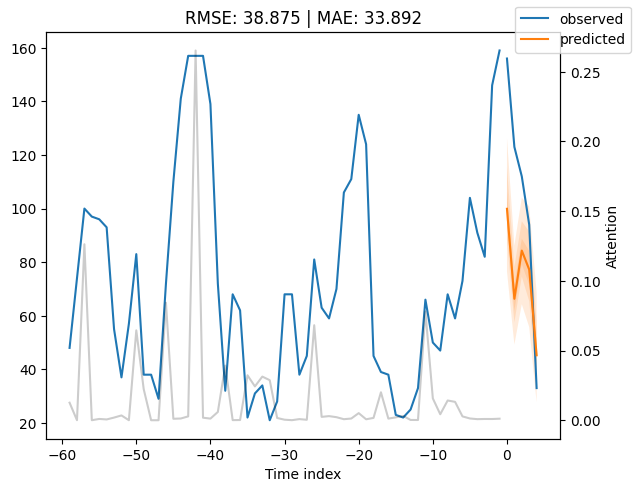

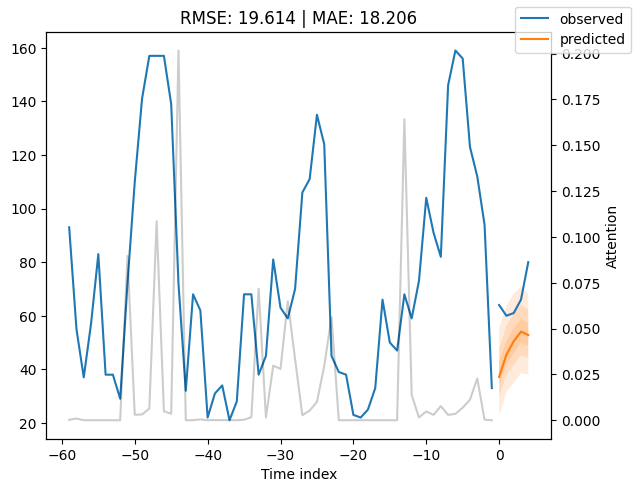

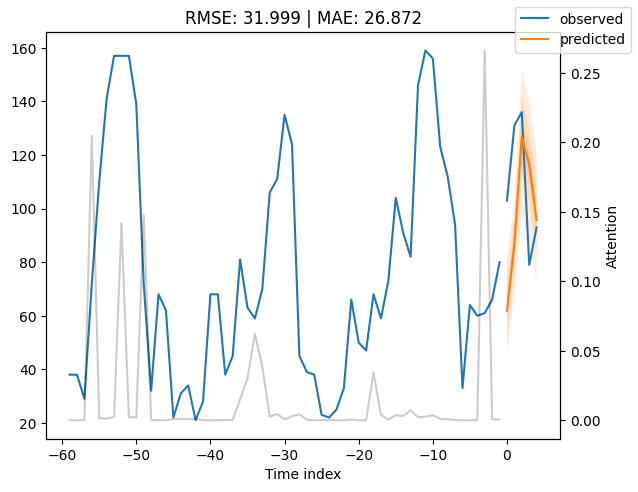

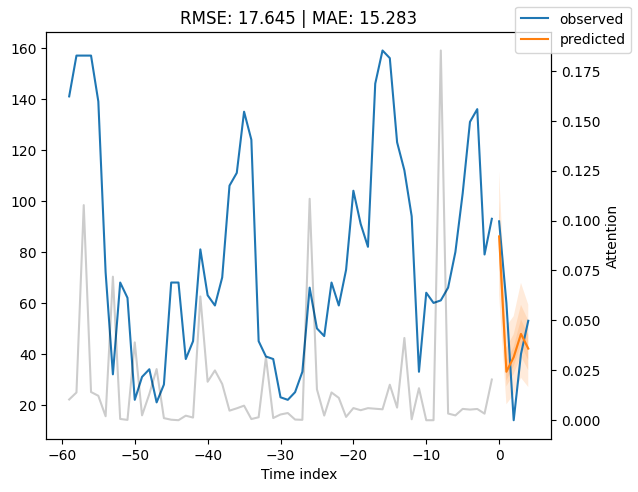

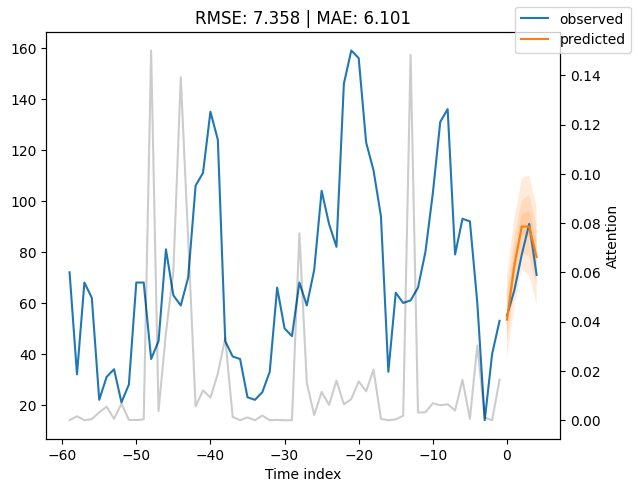

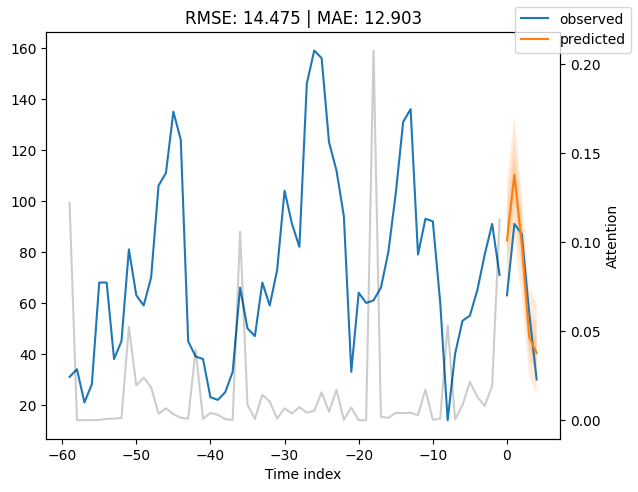

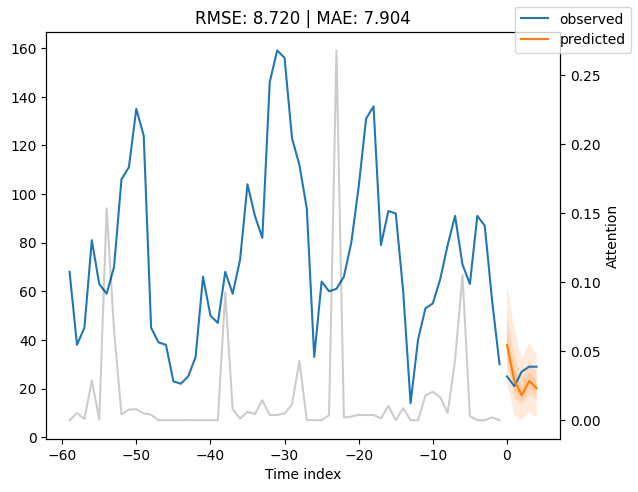

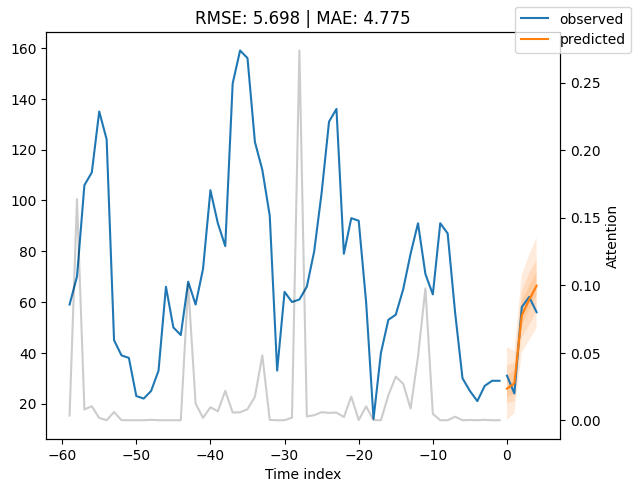

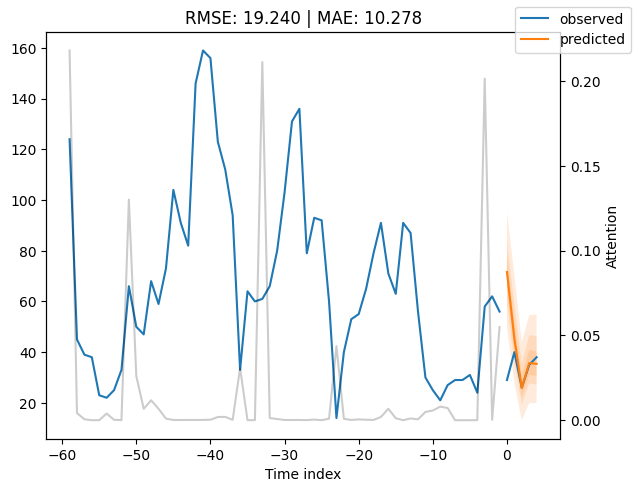

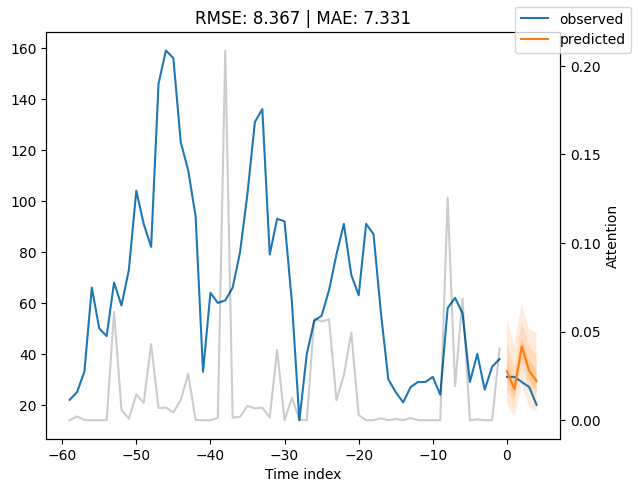

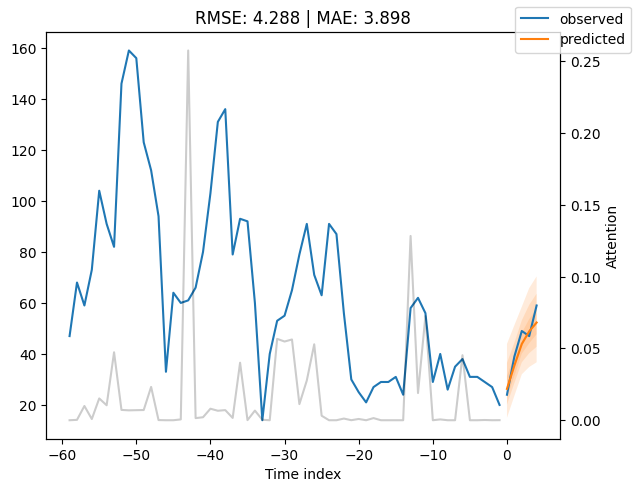

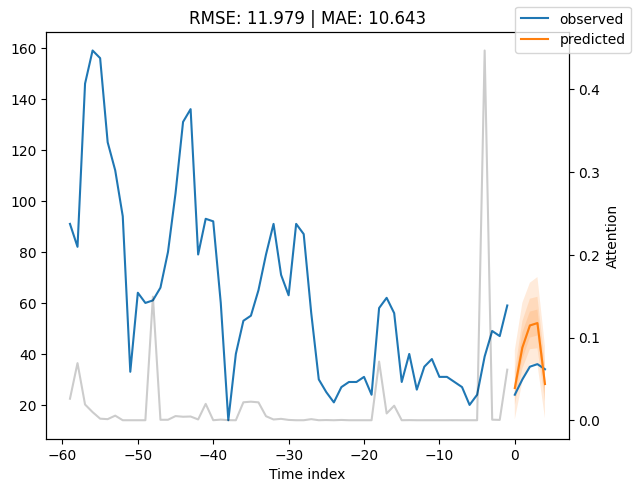

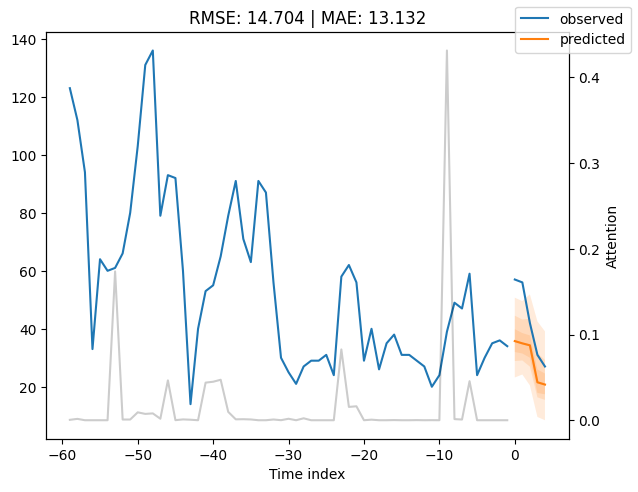

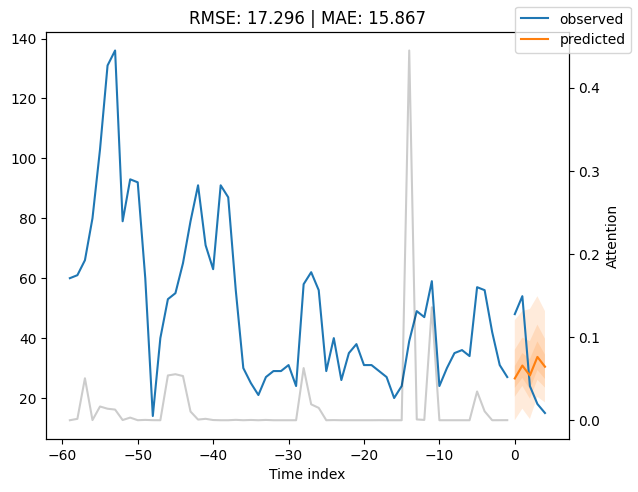

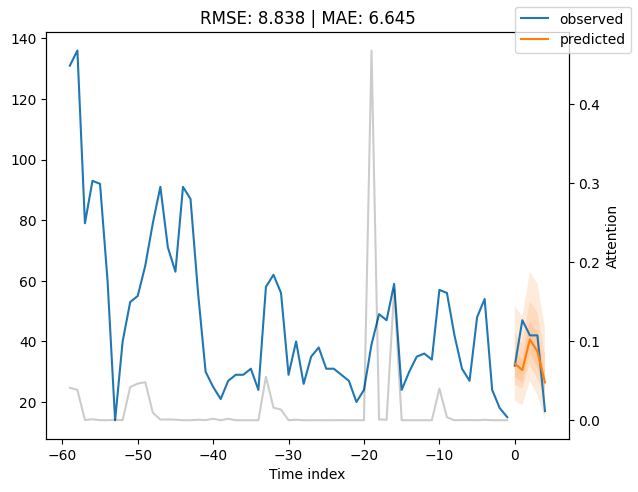

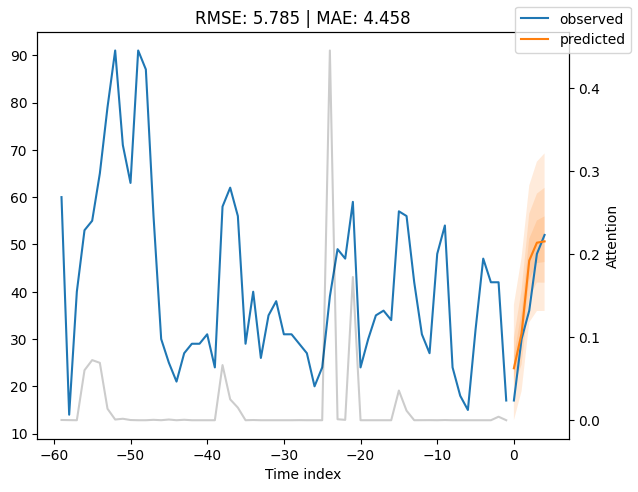

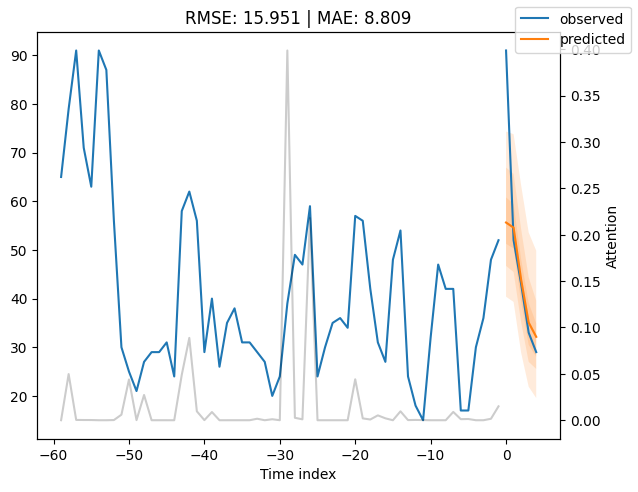

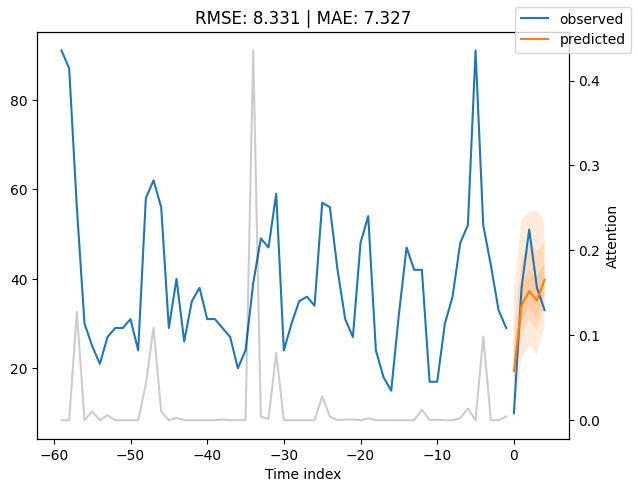

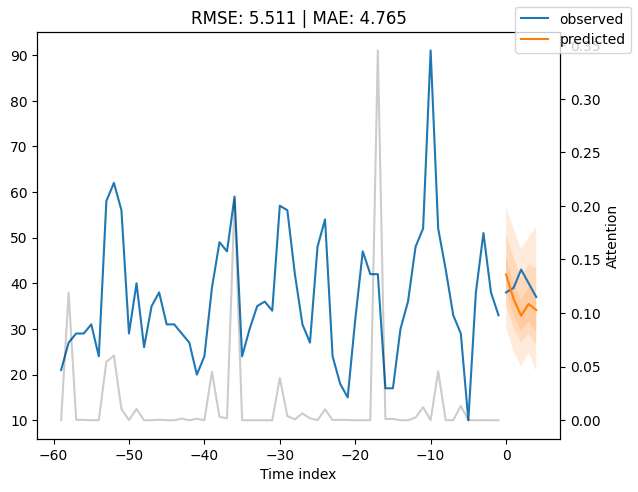

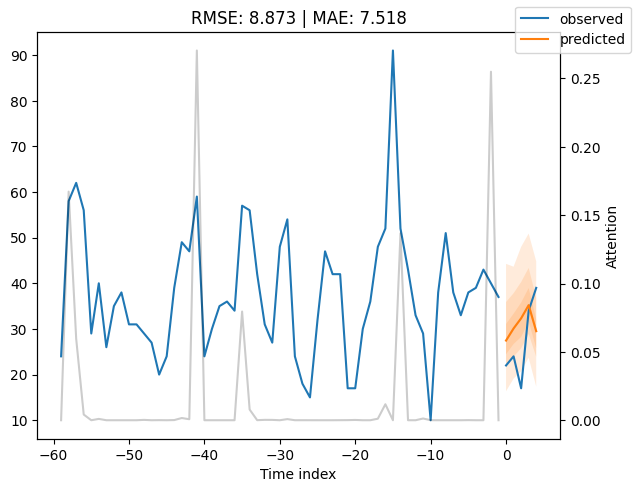


Global Metrics Across All Windows:
Global RMSE: 16.2254
Global MAE: 11.3303


In [37]:
test_df_lj = test_df[test_df['group']=='ljubljana']
results_df = evaluate_forecasting_windows(
    best_tft, 
    training, 
    test_df_lj, 
    lookback_window=60, 
    forecast_horizon=5, 
    step=5,
    plot=True)

In [38]:
test_df_bg = test_df[test_df['group']=='beograd']
results_df = evaluate_forecasting_windows(
    best_tft, 
    training, 
    test_df_bg, 
    lookback_window=60, 
    forecast_horizon=5, 
    plot=False)
print(results_df)


Global Metrics Across All Windows:
Global RMSE: 13.2429
Global MAE: 10.5627
    idx_range start_date   end_date       RMSE        MAE
0   1076-1140 2025-02-10 2025-02-14  14.856682  13.259537
1   1081-1145 2025-02-15 2025-02-19  20.309330  18.117313
2   1086-1150 2025-02-20 2025-02-24   9.911622   9.698308
3   1091-1155 2025-02-25 2025-03-01   9.133129   8.187861
4   1096-1160 2025-03-02 2025-03-06   9.536017   7.670142
5   1101-1165 2025-03-07 2025-03-11  21.163101  12.088899
6   1106-1170 2025-03-12 2025-03-16  13.936996  10.611734
7   1111-1175 2025-03-17 2025-03-21  15.839892  14.440689
8   1116-1180 2025-03-22 2025-03-26  21.271748  18.865793
9   1121-1185 2025-03-27 2025-03-31   6.350908   4.072671
10  1126-1190 2025-04-01 2025-04-05   8.538032   7.385236
11  1131-1195 2025-04-06 2025-04-10  13.668356  12.826596
12  1136-1200 2025-04-11 2025-04-15  12.719770   9.107087
13  1141-1205 2025-04-16 2025-04-20  12.984658  11.574324
14  1146-1210 2025-04-21 2025-04-25  16.202396  15.08

In [39]:
results_df.drop(columns=['idx_range', 'start_date', 'end_date']).describe()

RMSE        MAE
count  20.000000  20.000000
mean   12.378131  10.562742
std     4.829201   4.049649
min     5.760315   4.072671
25%     8.984355   7.598915
50%    12.128599  10.155021
75%    15.102484  12.934831
max    21.271748  18.865793

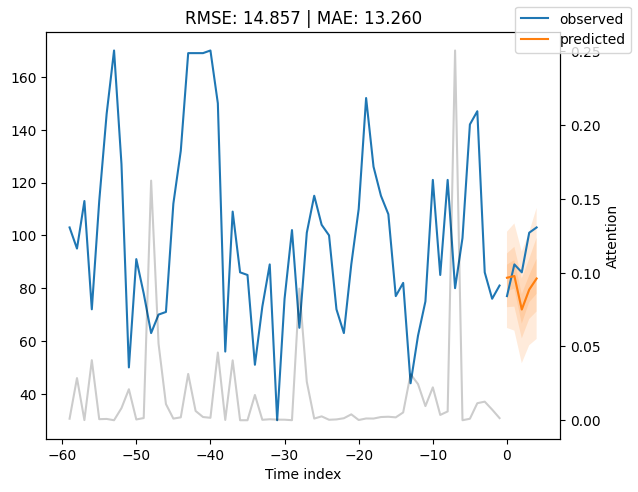

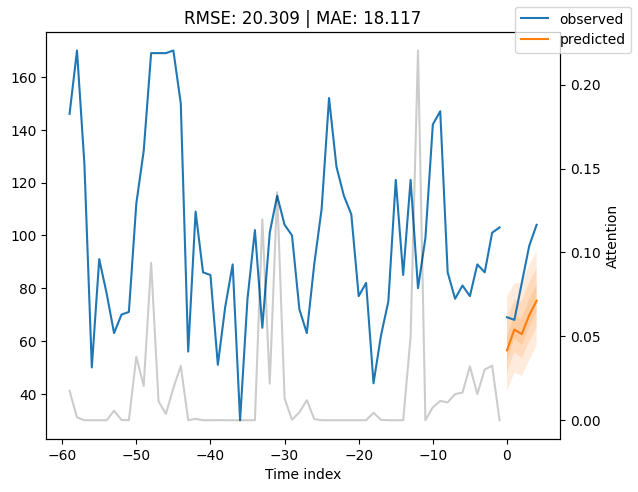

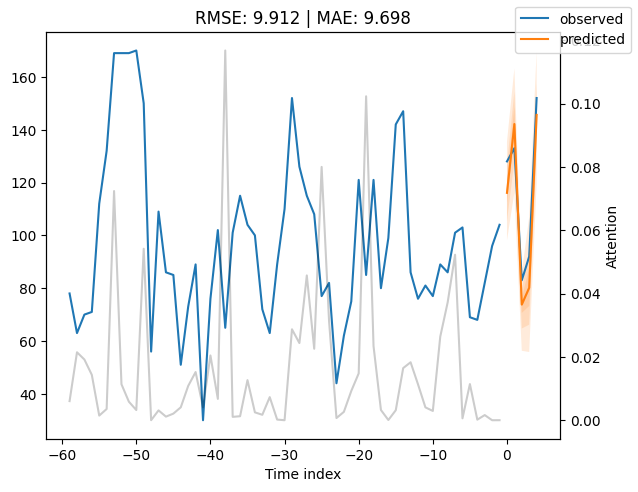

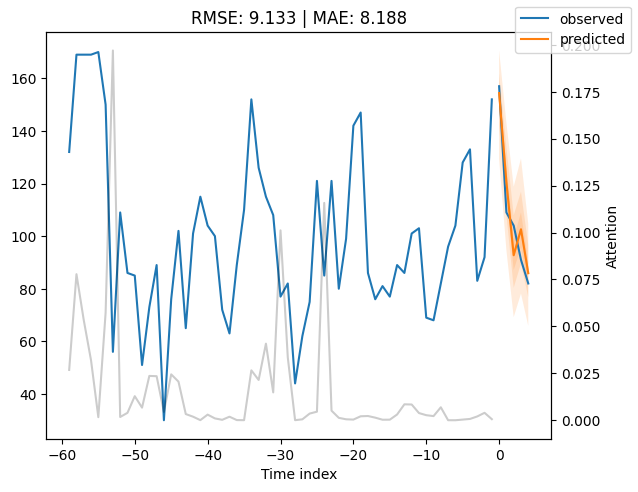

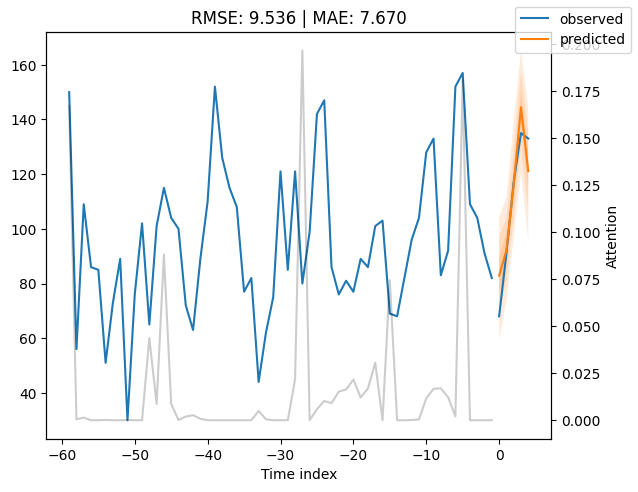

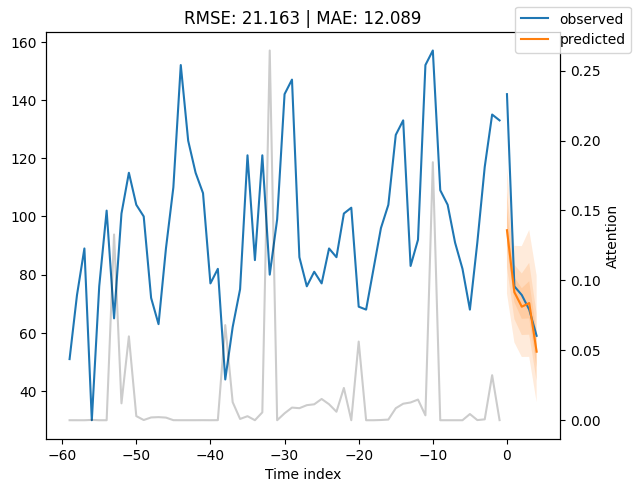

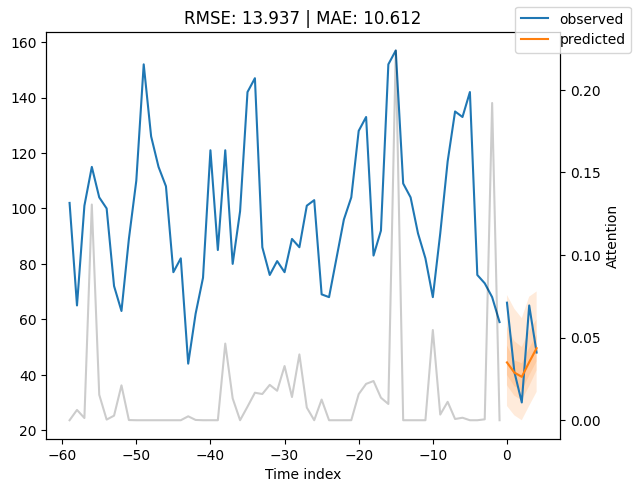

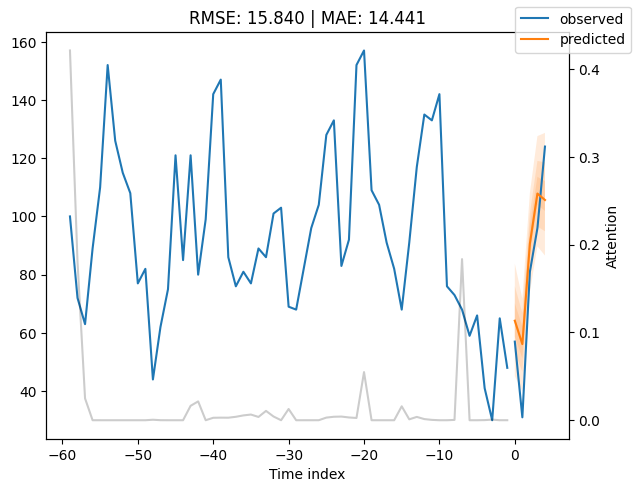

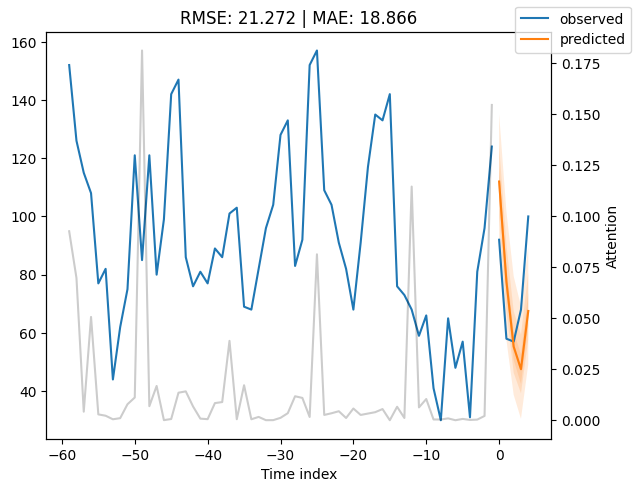

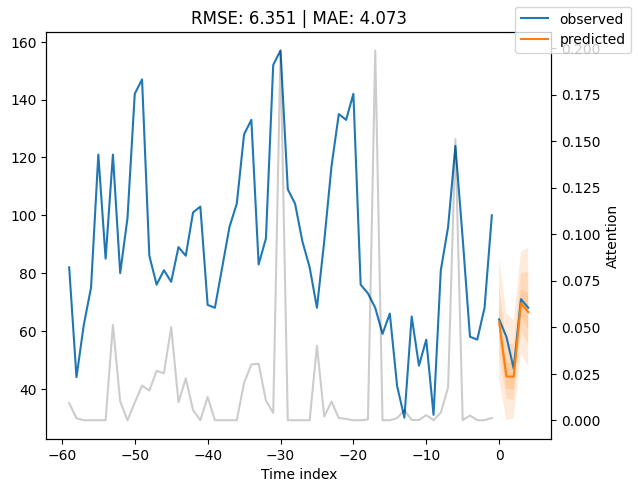

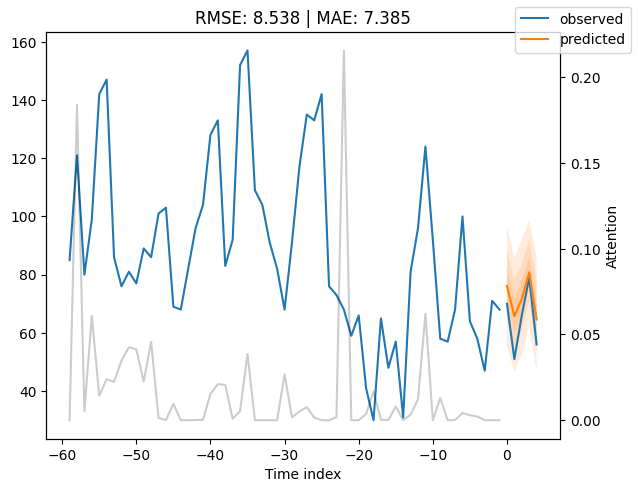

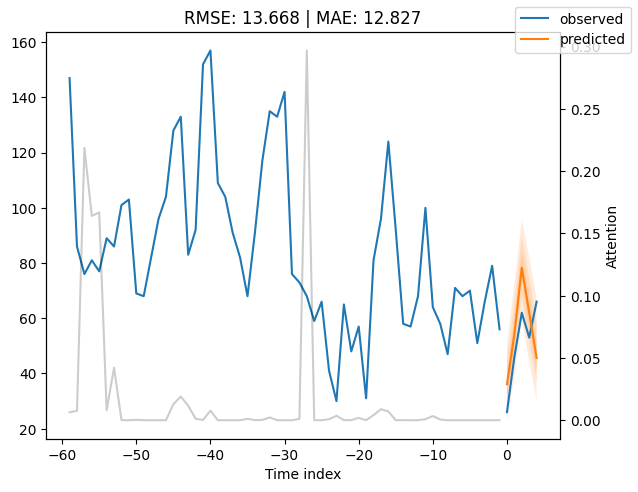

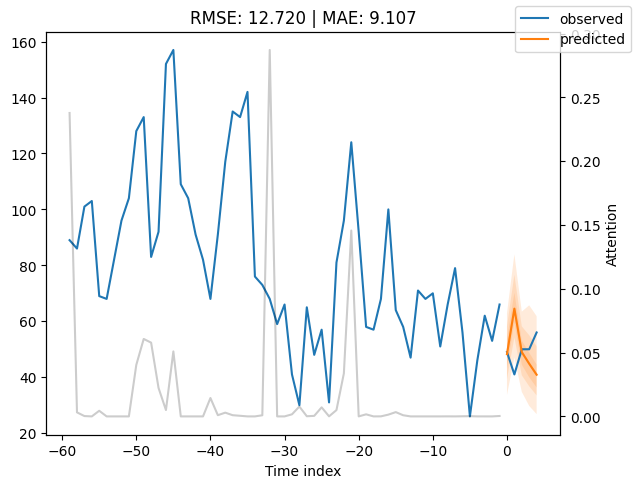

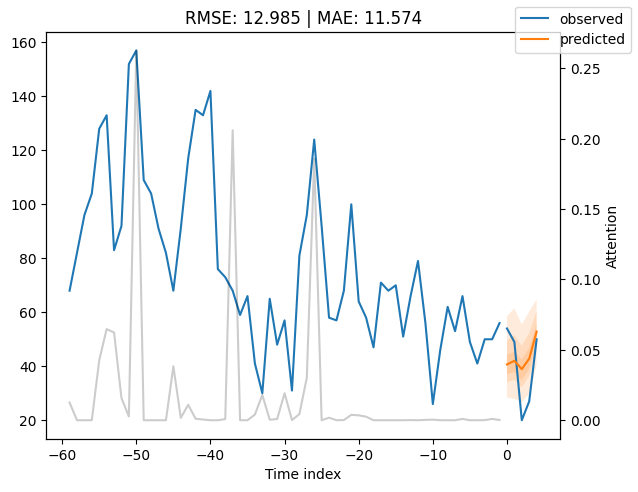

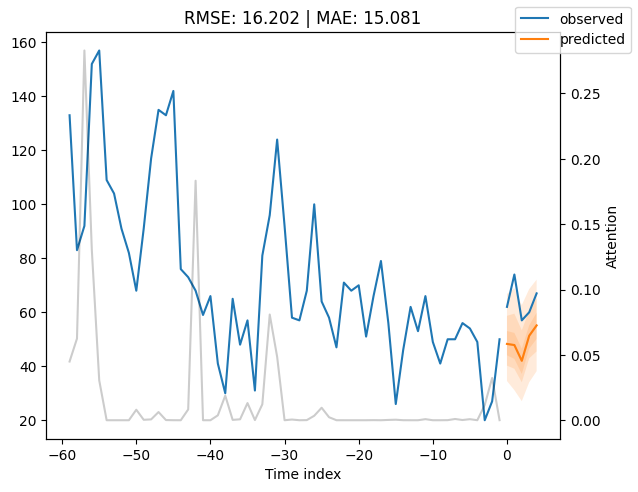

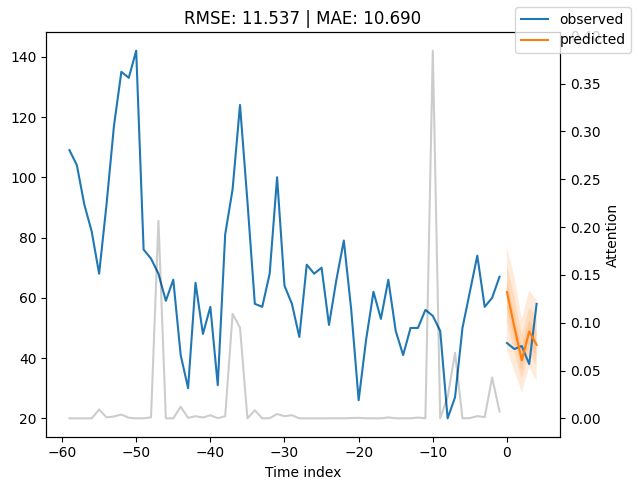

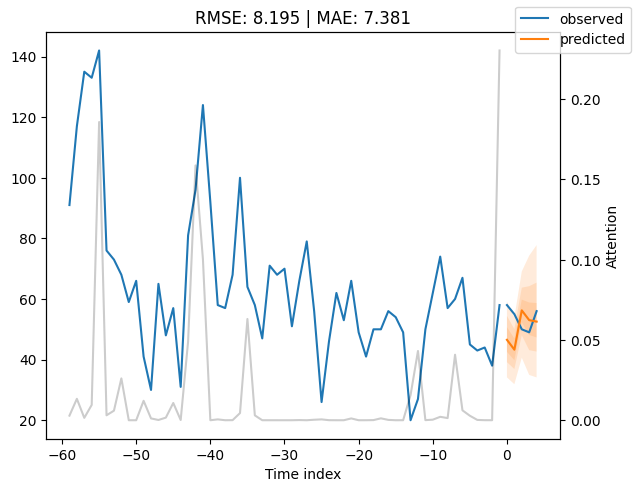

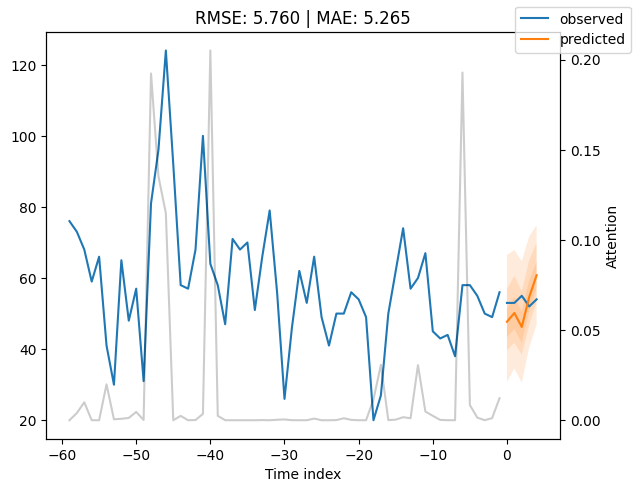

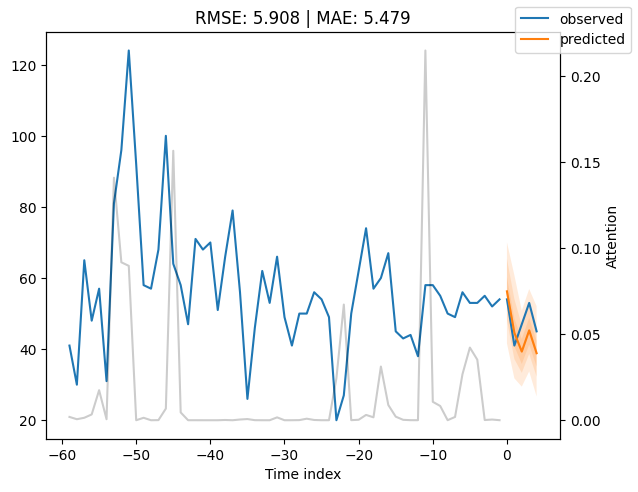

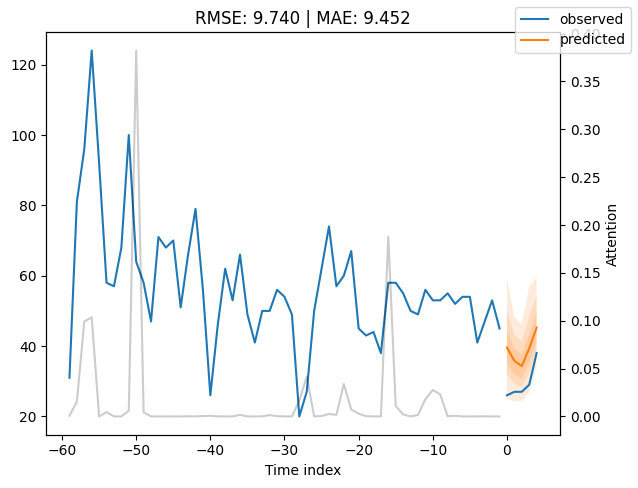


Global Metrics Across All Windows:
Global RMSE: 13.2429
Global MAE: 10.5627


In [40]:
test_df_bg = test_df[test_df['group']=='beograd']
results_df = evaluate_forecasting_windows(
    best_tft, 
    training, 
    test_df_bg, 
    lookback_window=60, 
    forecast_horizon=5, 
    plot=True)

## Interpretability

In [207]:
def interprete_predictions(model, training_dataset, test_df, start_idx, lookback_window, forecast_horizon):
    test_slice = test_df[
            (test_df.time_idx >= start_idx - lookback_window) &
            (test_df.time_idx <= start_idx + forecast_horizon - 1)
        ]
        
    # create dataset and dataloader
    test_dataset = TimeSeriesDataSet.from_dataset(training_dataset, test_slice, predict=True, stop_randomization=True)
    test_dataloader = test_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
    raw_predictions = model.predict(test_dataloader, mode="raw", return_x=True)
    interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
    best_tft.plot_interpretation(interpretation)

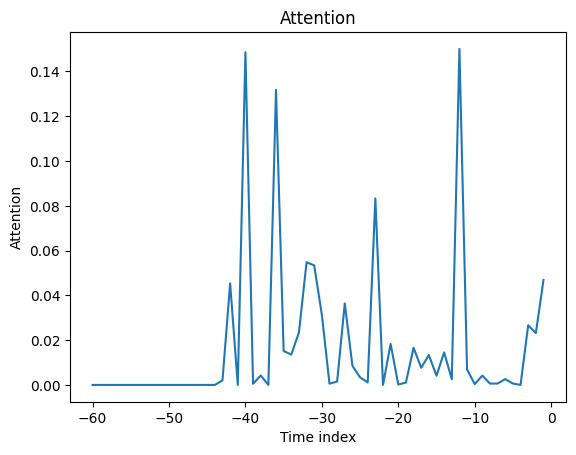

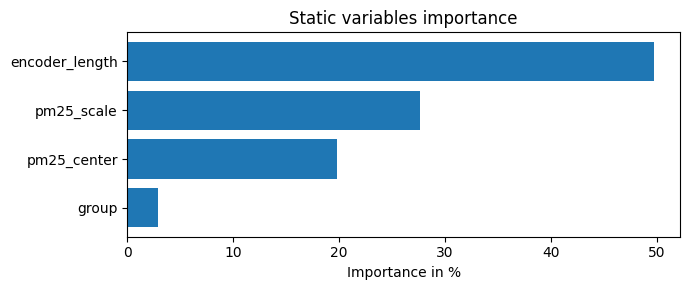

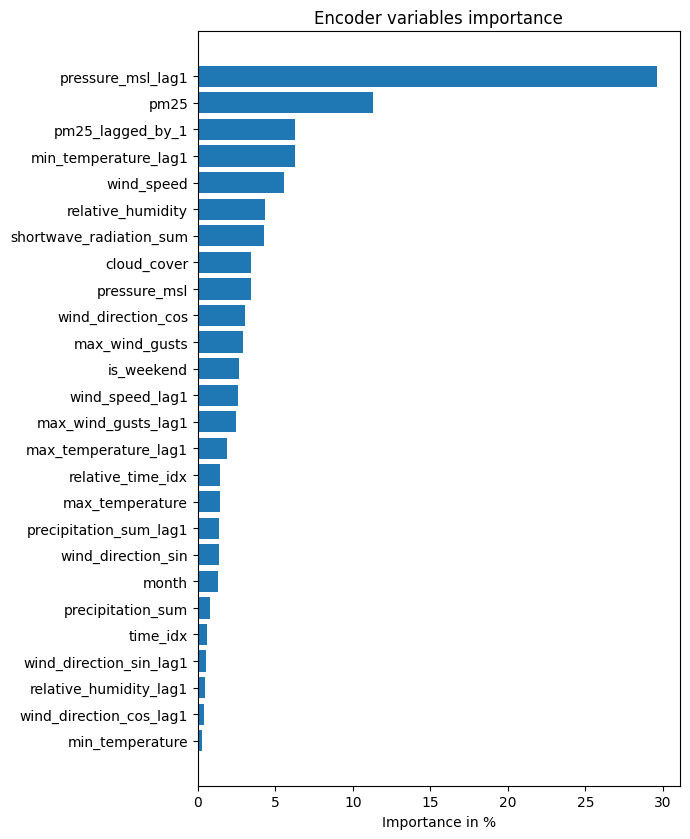

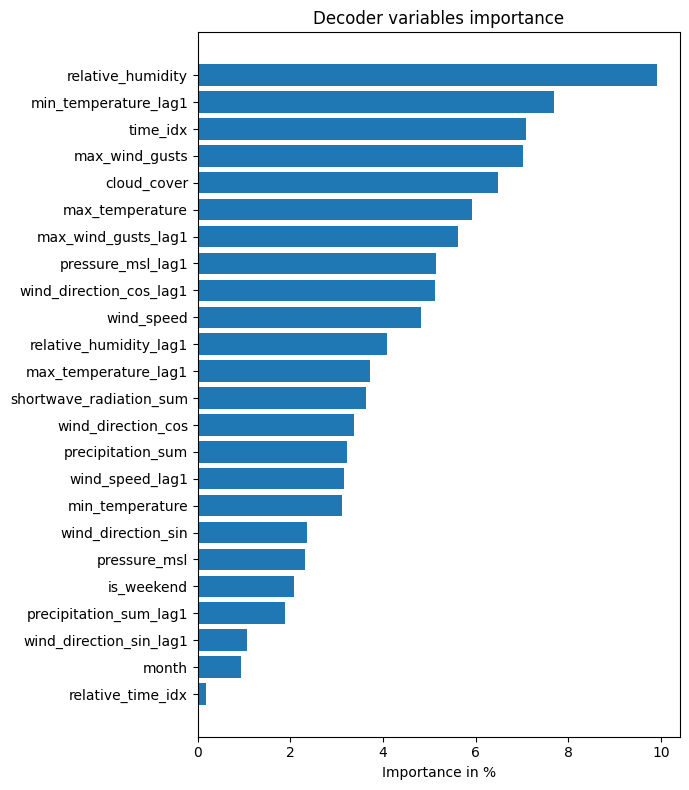

In [208]:
interprete_predictions(best_tft, training, test_df_bg, start_idx=1120, lookback_window=60, forecast_horizon=5)

In [122]:
def compute_mean_importances(model, training_dataset, test_df, lookback_window=60, forecast_horizon=5, initial_start_idx=1135, step_size=5):
    all_encoder_importances = []
    all_decoder_importances = []
    encoder_vars = None
    decoder_vars = None

    max_possible_start = test_df["time_idx"].max() - forecast_horizon + 1
    start_indices = range(initial_start_idx, max_possible_start, step_size)
    
    for start_idx in tqdm(start_indices):
        test_slice = test_df[
            (test_df["time_idx"] >= start_idx - lookback_window) &
            (test_df["time_idx"] <= start_idx + forecast_horizon - 1)
        ]
        
        # skip incomplete windows
        expected_length = lookback_window + forecast_horizon
        if len(test_slice) != expected_length:
            continue

        test_dataset = TimeSeriesDataSet.from_dataset(
            training_dataset, test_slice, predict=True, stop_randomization=True
        )
        test_dataloader = test_dataset.to_dataloader(
            train=False, batch_size=1000, num_workers=0
        )
        
        raw_predictions = model.predict(test_dataloader, mode="raw", return_x=True)
        interpretation = model.interpret_output(raw_predictions.output, reduction="sum")
        
        if encoder_vars is None:
            params = training_dataset.get_parameters()
            encoder_vars = params['time_varying_known_categoricals'] + params['time_varying_known_reals'] + ['relative_time_idx'] + params['time_varying_unknown_reals'] + ['pm25_lagged_by_1']
            decoder_vars = params['time_varying_known_categoricals'] + params['time_varying_known_reals'] + ['relative_time_idx']

        all_encoder_importances.append(interpretation["encoder_variables"])
        all_decoder_importances.append(interpretation["decoder_variables"])
    
    return {
        # Encoder stats
        "mean_encoder": np.mean(all_encoder_importances, axis=0),
        "std_encoder": np.std(all_encoder_importances, axis=0),
        "encoder_vars": encoder_vars,
        
        # Decoder stats
        "mean_decoder": np.mean(all_decoder_importances, axis=0), 
        "std_decoder": np.std(all_decoder_importances, axis=0),
        "decoder_vars": decoder_vars,

        "n_windows": len(all_encoder_importances)
    }

In [148]:
def plot_importances_with_std(results, figsize=(13, 4), location='Belgrade', save_path=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Encoder plot with error bars
    encoder_df = pd.DataFrame({
        "Variable": results["encoder_vars"],
        "Mean": results["mean_encoder"],
        "Std": results["std_encoder"]
    }).sort_values("Mean", ascending=False)
    
    ax1.barh(encoder_df["Variable"], encoder_df["Mean"], 
             xerr=encoder_df["Std"], color="royalblue", alpha=0.7)
    ax1.set_title(f"Average encoder variables importance ({location})")
    ax1.set_xlabel("Importance ± STD")
    
    # Decoder plot with error bars  
    decoder_df = pd.DataFrame({
        "Variable": results["decoder_vars"],
        "Mean": results["mean_decoder"],
        "Std": results["std_decoder"]
    }).sort_values("Mean", ascending=False)
    
    ax2.barh(decoder_df["Variable"], decoder_df["Mean"],
             xerr=decoder_df["Std"], color="orange", alpha=0.7)
    ax2.set_title(f"Average decoder variables importance ({location})")
    ax2.set_xlabel("Importance ± STD")
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Plot saved to {save_path}")
        
    plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.36it/s]


Plot saved to ljubljana_importance_12x5.png


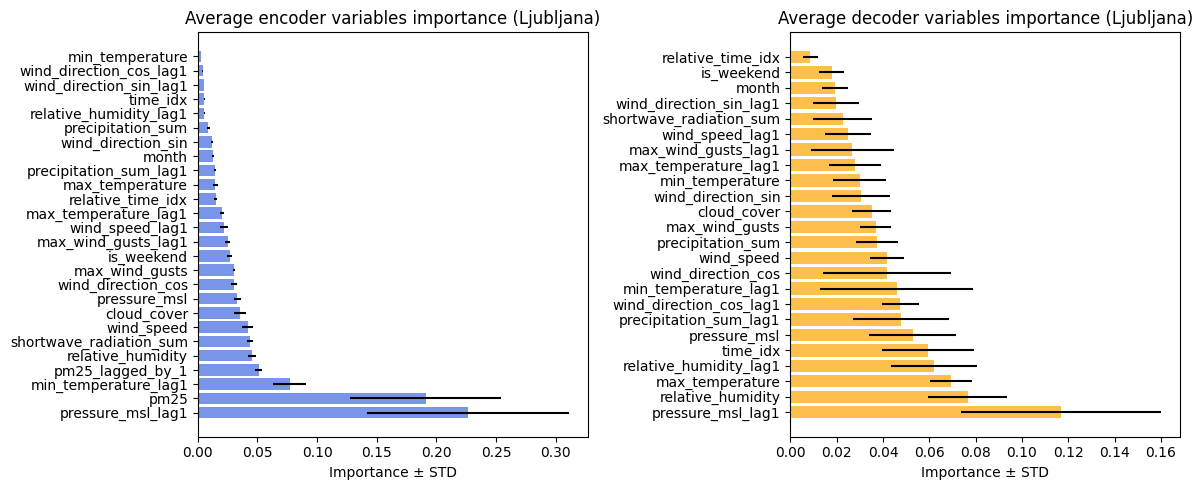

In [169]:
from tqdm import tqdm

results = compute_mean_importances(
    model=best_tft,
    training_dataset = training,
    test_df=test_df_lj,
    lookback_window=60,
    forecast_horizon=5
)

plot_importances_with_std(results, figsize=(12, 5), location = 'Ljubljana',  save_path = 'ljubljana_importance_12x5.png')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.10it/s]


Plot saved to beograd_importance_12x5.png


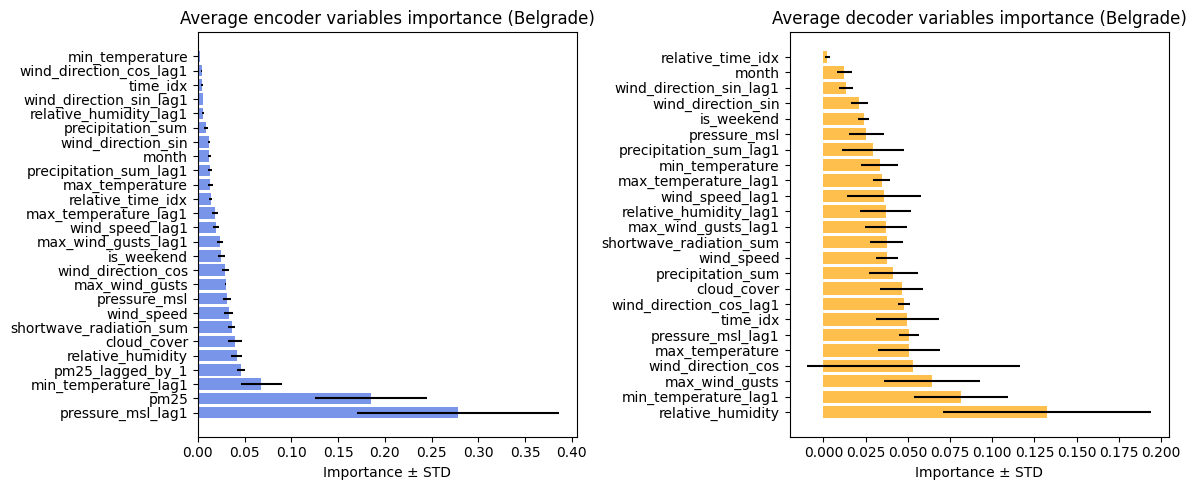

In [170]:
results = compute_mean_importances(
    model=best_tft,
    training_dataset = training,
    test_df=test_df_bg,
    lookback_window=60,
    forecast_horizon=5
)

plot_importances_with_std(results, figsize=(12, 5), location = 'Belgrade', save_path = 'beograd_importance_12x5.png')

In [162]:
test_dataset = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=10*64, num_workers=0)
predictions = best_tft.predict(test_dataloader, return_x=True, trainer_kwargs=dict(accelerator="cpu"))
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
filtered_results = copy.deepcopy(predictions_vs_actuals)
for key in ['prediction', 'actual', 'support']:
    if key in filtered_results:
        filtered_results[key] = {
            k: v for k, v in filtered_results[key].items()
            if not k.startswith('pm25_lagged_by_')
        }

os.makedirs("test_avg_plots", exist_ok=True)
plt.ioff()

best_tft.plot_prediction_actual_by_variable(filtered_results)

for i, fig in enumerate(plt.get_fignums()):
    plt.figure(fig).savefig(f"test_avg_plots/variable_{i}.png")
    plt.close(fig)

plt.ion()

C:\Users\Korisnik\anaconda3\envs\tft_env\Lib\site-packages\pytorch_forecasting\models\base_model.py:2221: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(**kwargs)


C:\Users\Korisnik\anaconda3\envs\tft_env\Lib\site-packages\pytorch_forecasting\models\base_model.py:2221: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(**kwargs)


{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'pm25_center': <Figure size 1000x500 with 2 Axes>,
 'pm25_scale': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'precipitation_sum': <Figure size 1000x500 with 2 Axes>,
 'relative_humidity': <Figure size 1000x500 with 2 Axes>,
 'min_temperature': <Figure size 1000x500 with 2 Axes>,
 'max_temperature': <Figure size 1000x500 with 2 Axes>,
 'pressure_msl': <Figure size 1000x500 with 2 Axes>,
 'wind_speed': <Figure size 1000x500 with 2 Axes>,
 'max_wind_gusts': <Figure size 1000x500 with 2 Axes>,
 'cloud_cover': <Figure size 1000x500 with 2 Axes>,
 'shortwave_radiation_sum': <Figure size 1000x500 with 2 Axes>,
 'wind_direction_cos': <Figure size 1000x500 with 2 Axes>,
 'wind_direction_sin': <Figure size 1000x500 with 2 Axes>,
 'max_wind_gusts_lag1': <Figure size 1000x500 with 2 Axes>,
 'wind_speed_lag1': <Figure size 1000x500 with 2 Axes>,
 'wind_direction_sin_lag1': <Figure size 1000x500 with 2

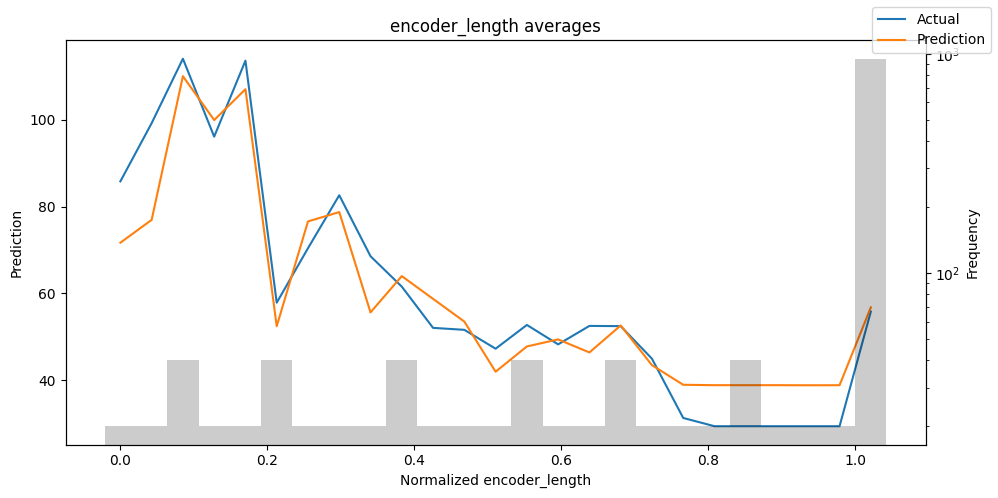

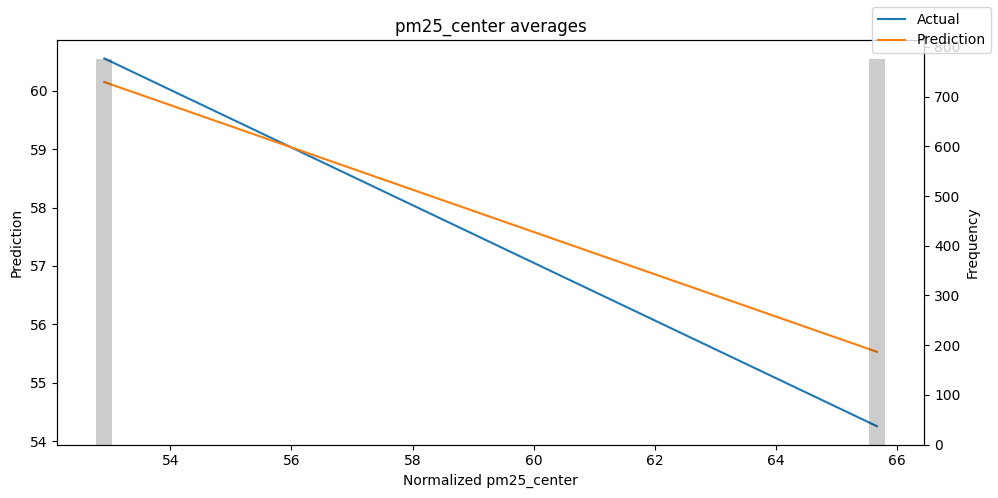

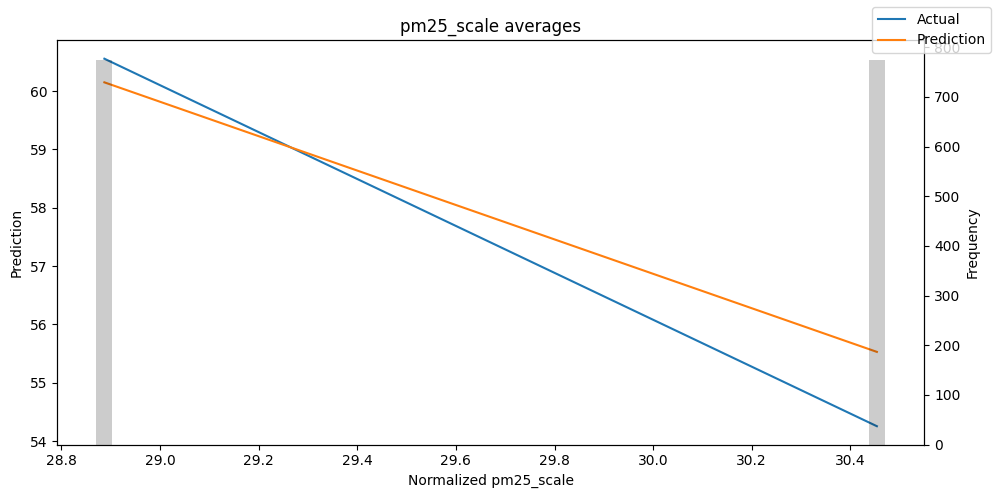

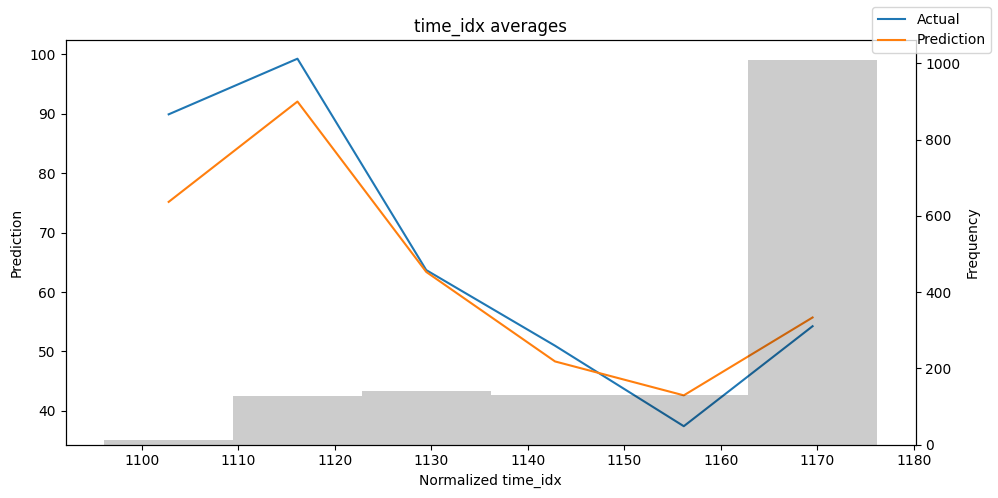

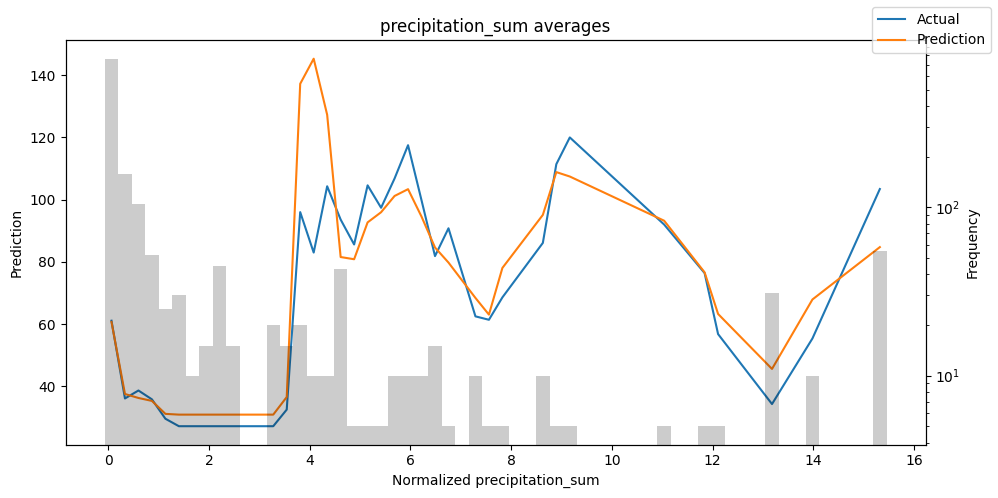

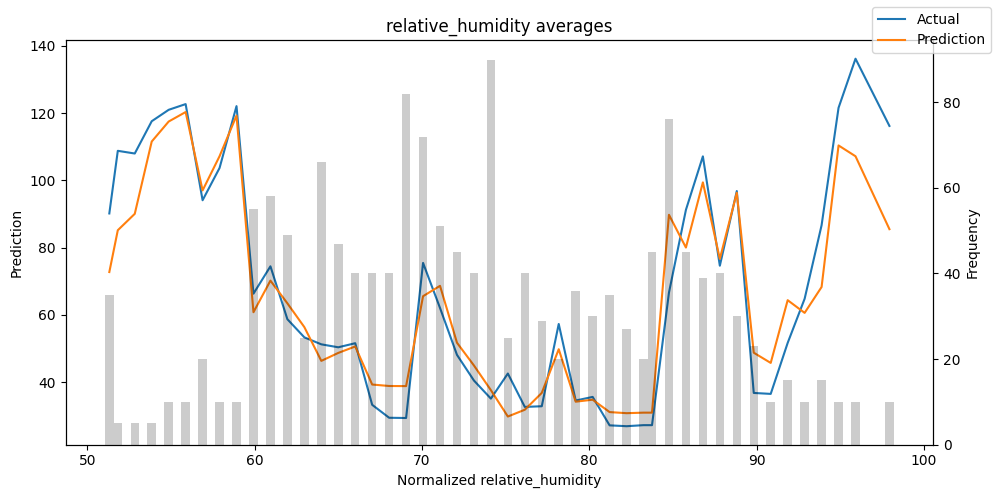

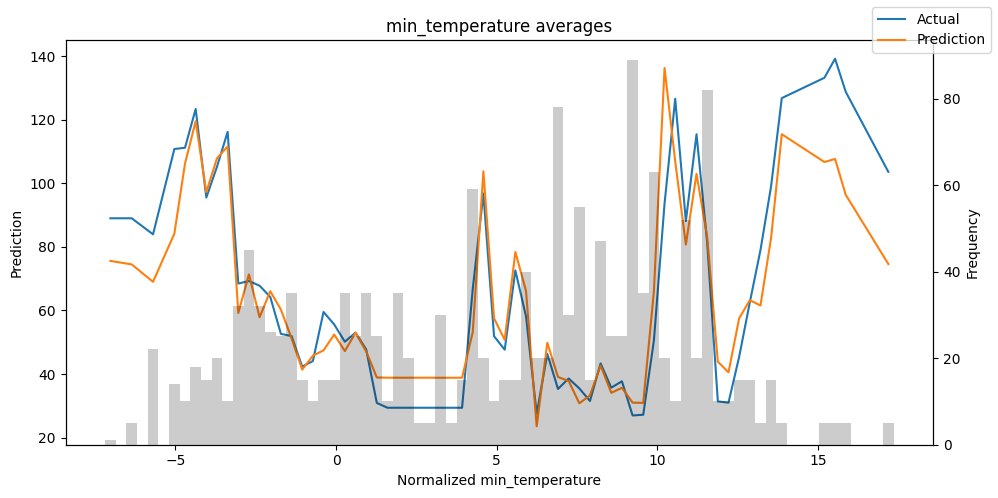

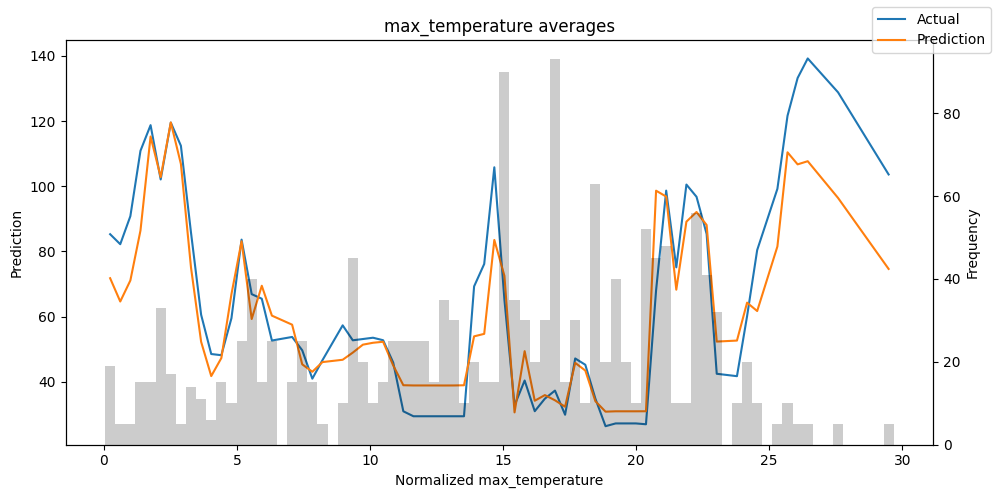

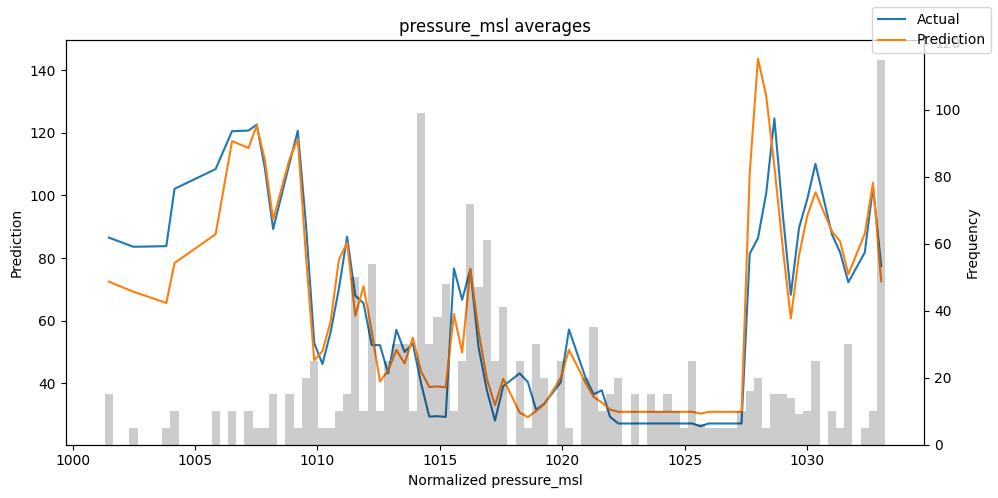

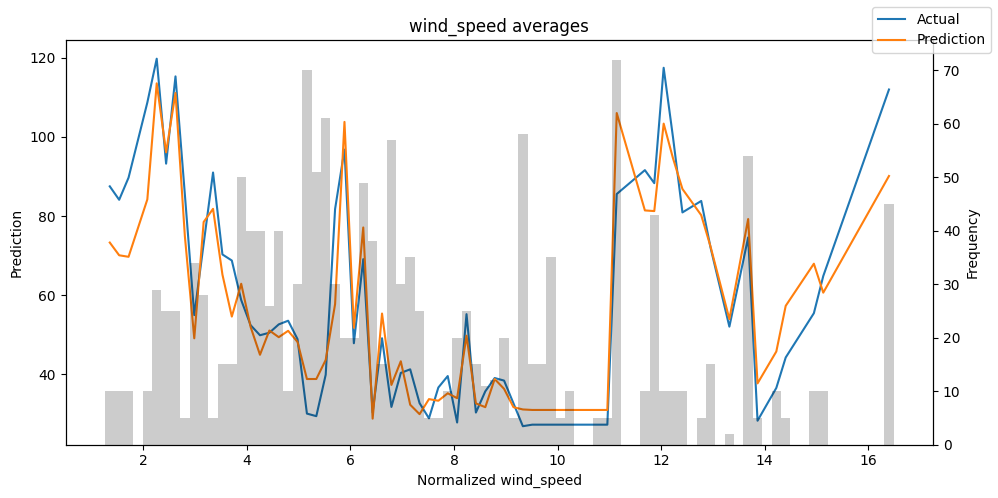

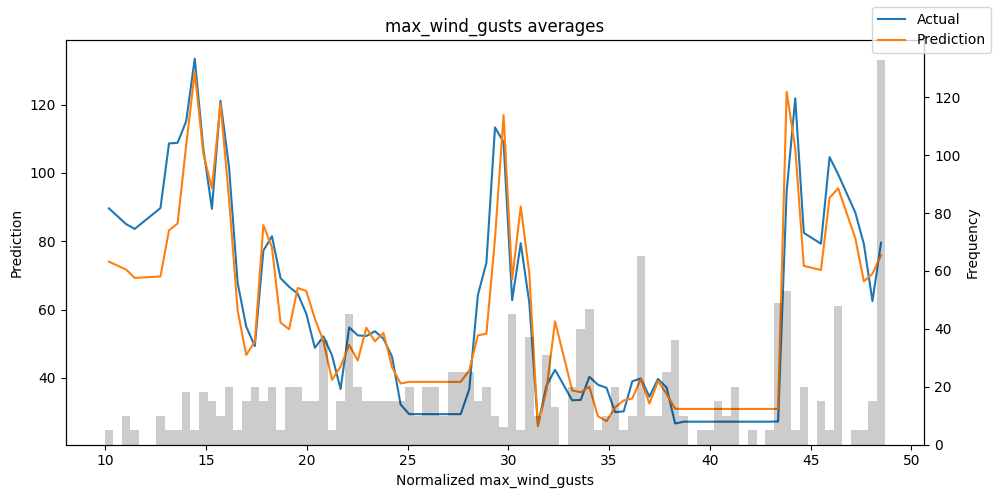

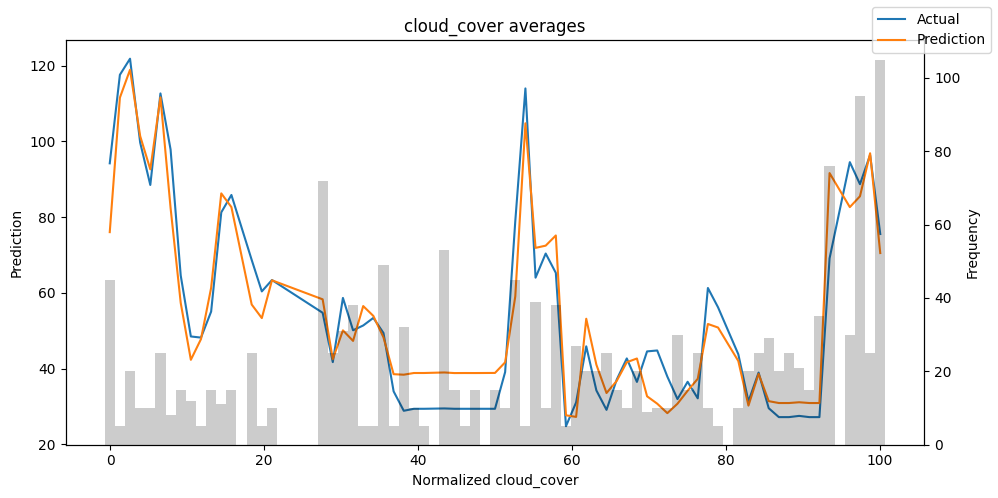

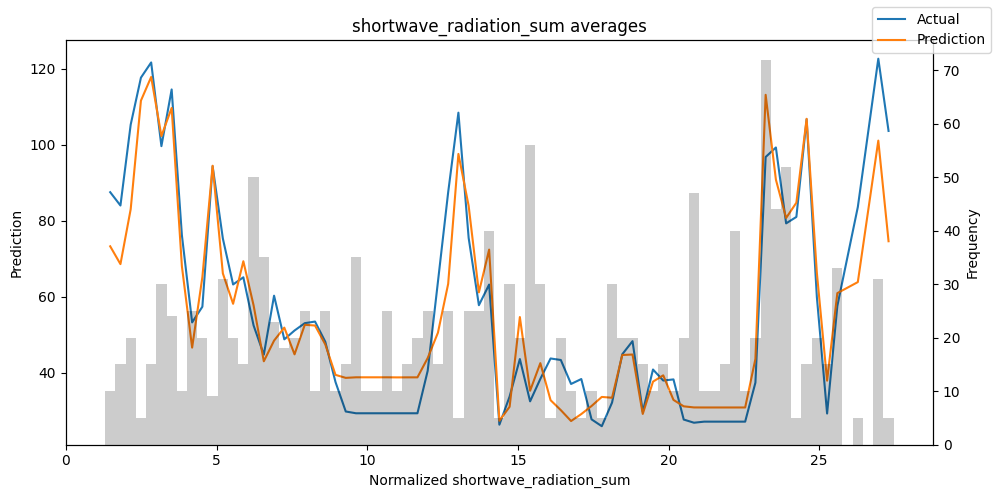

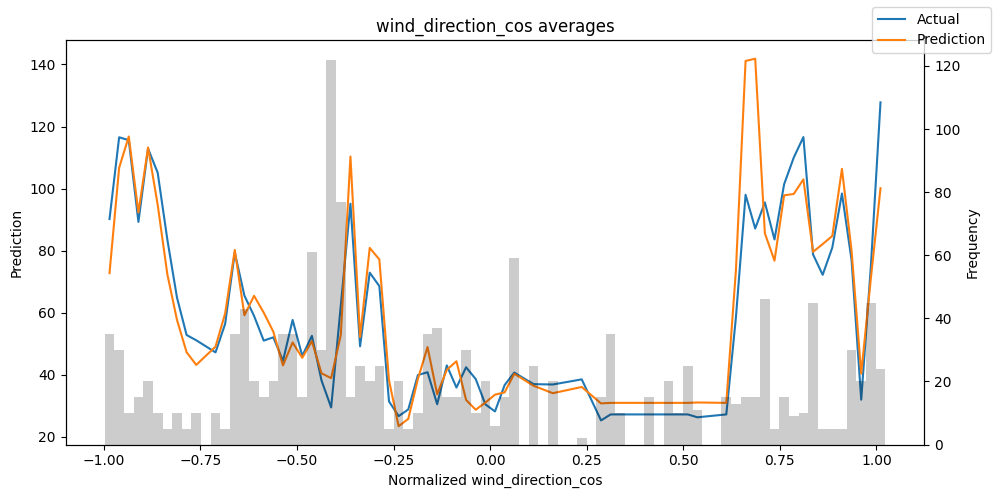

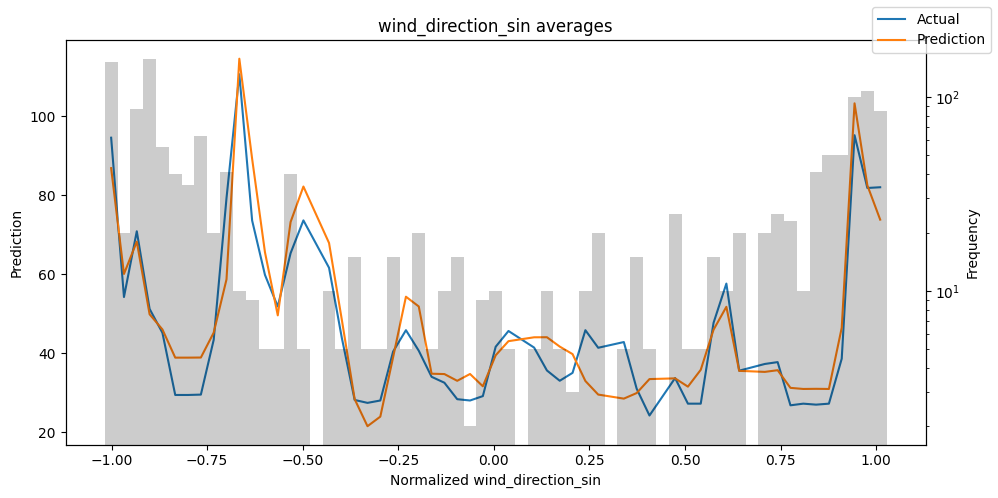

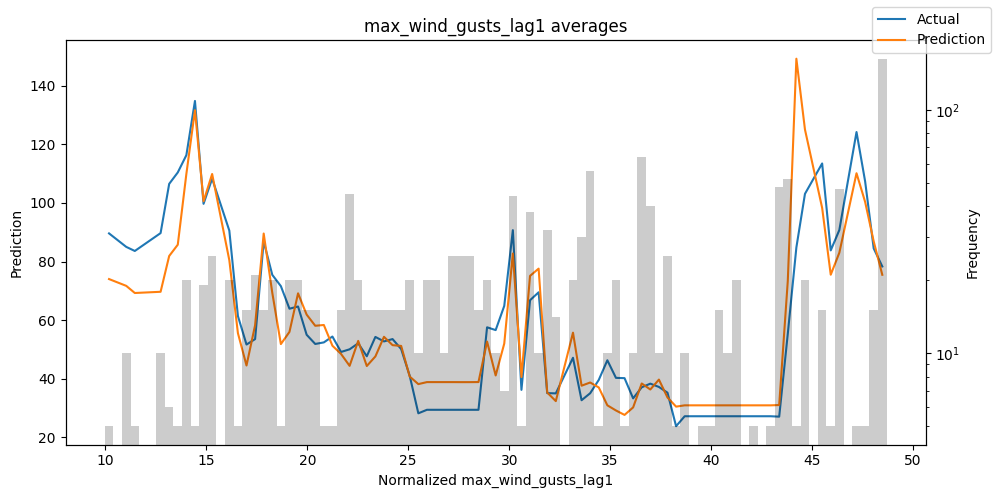

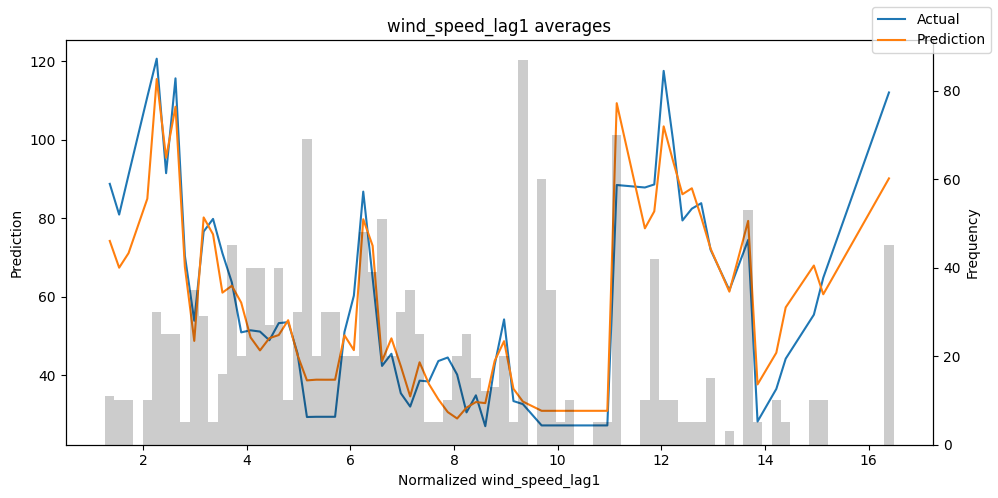

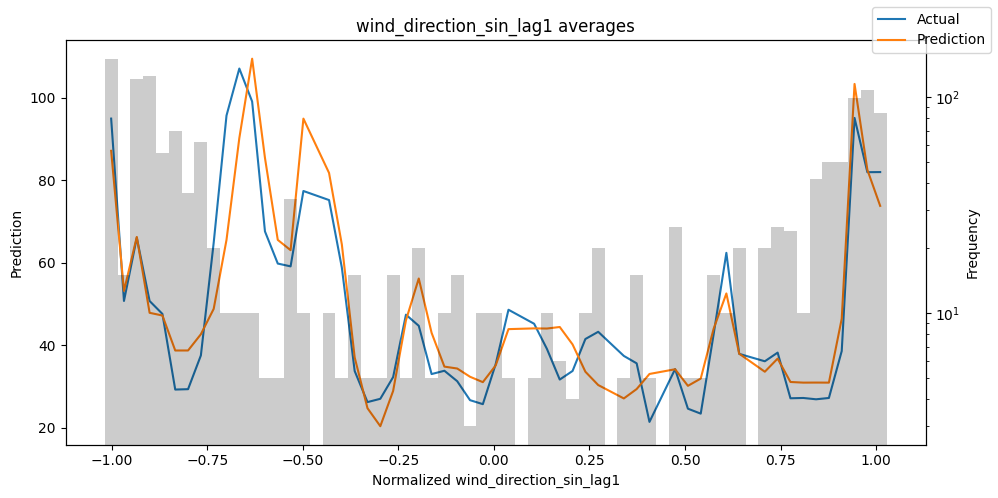

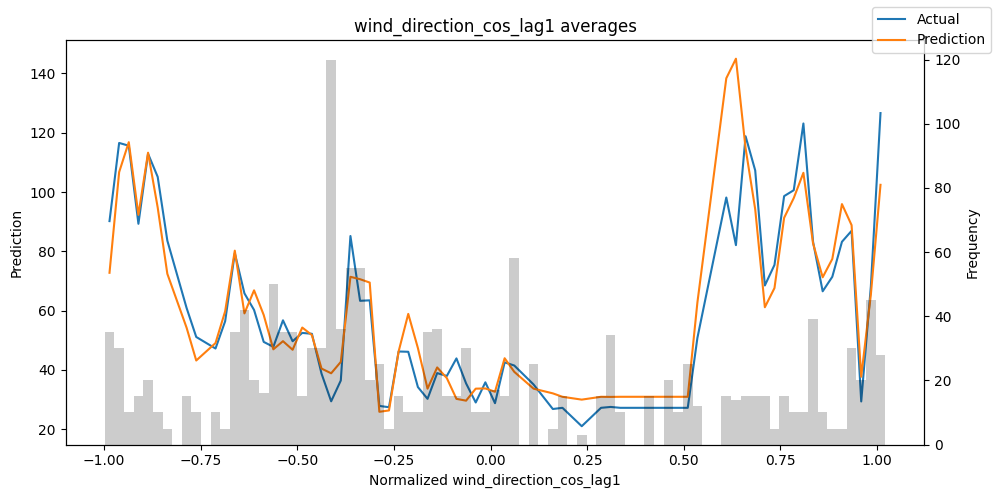

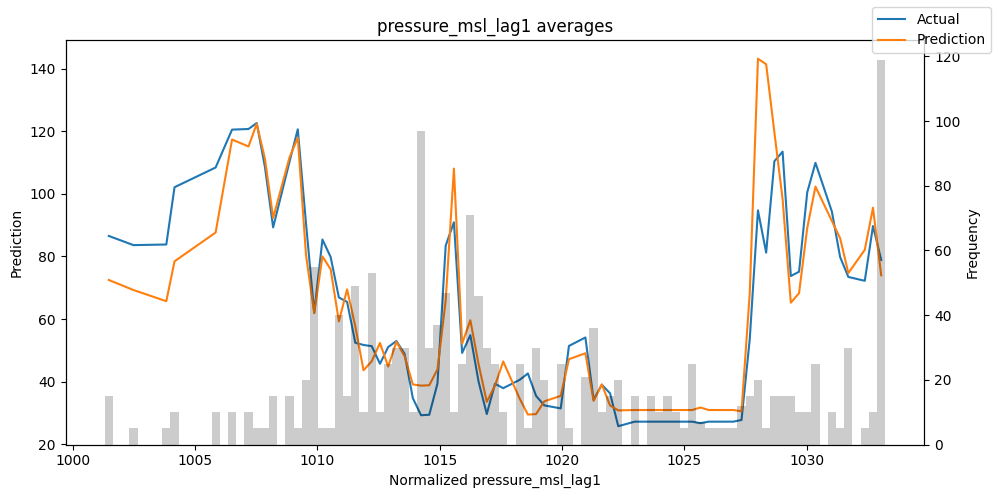

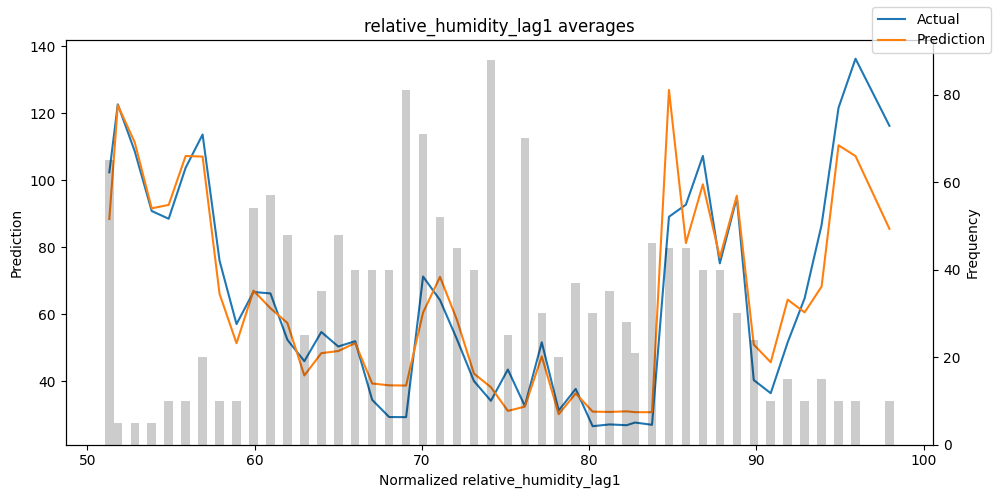

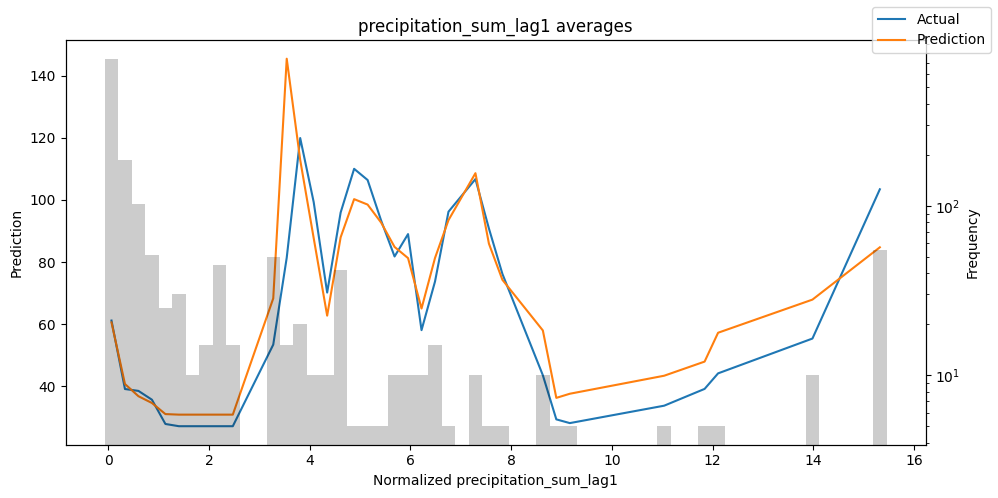

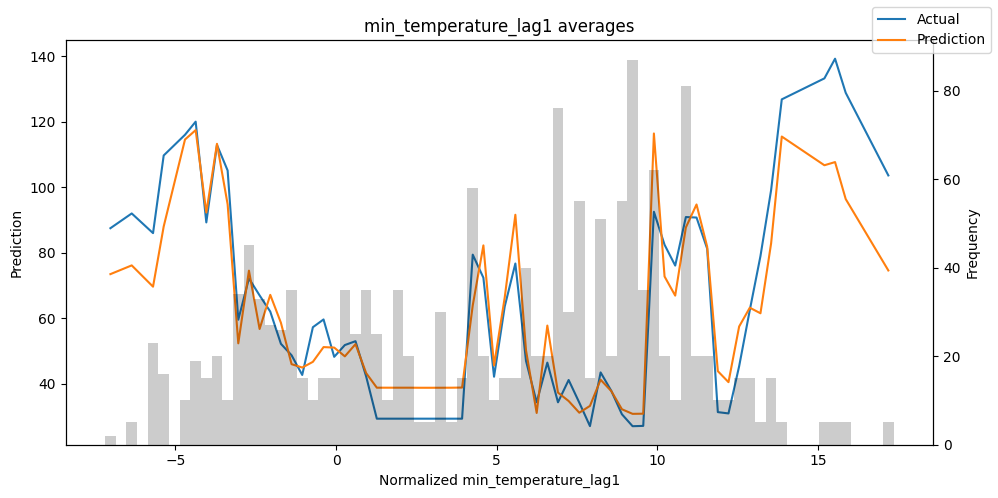

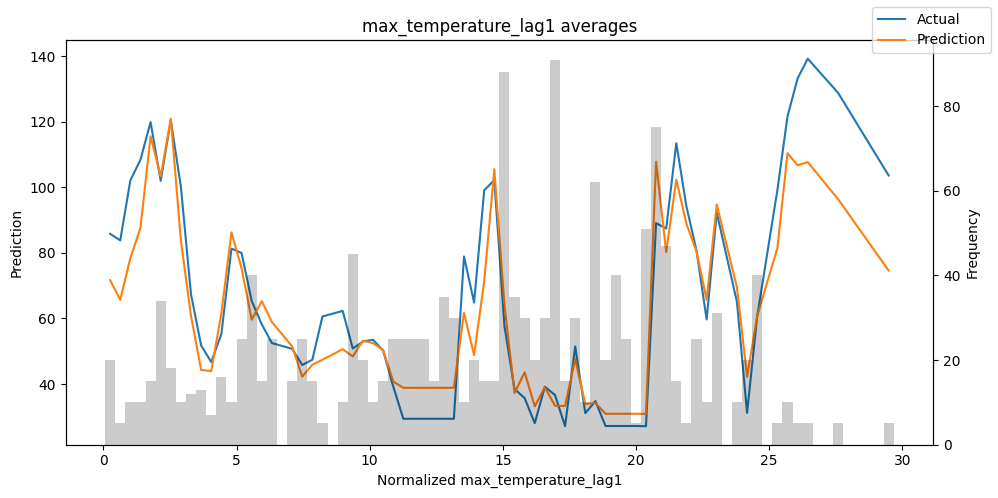

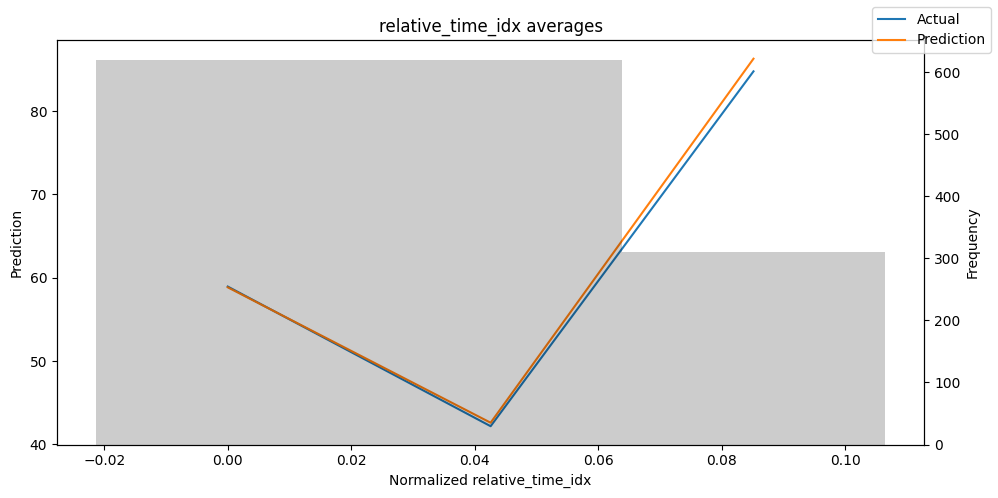

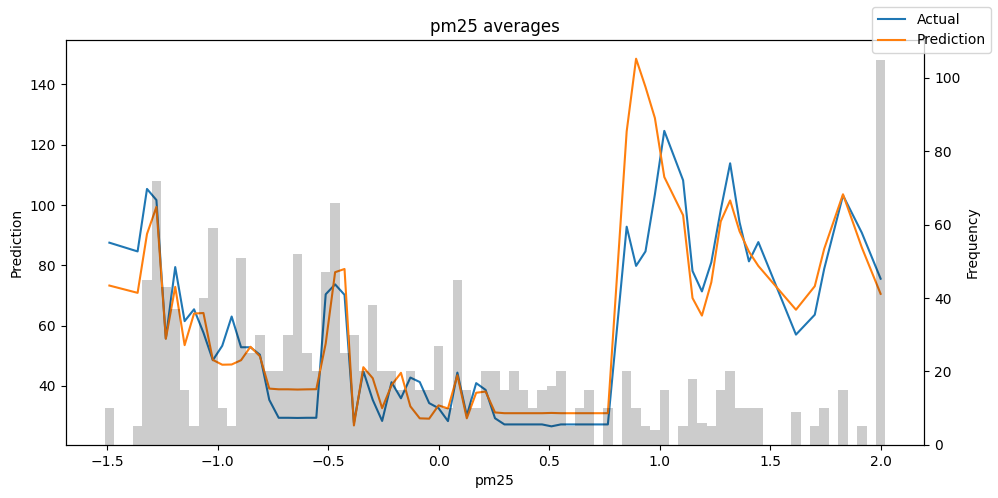

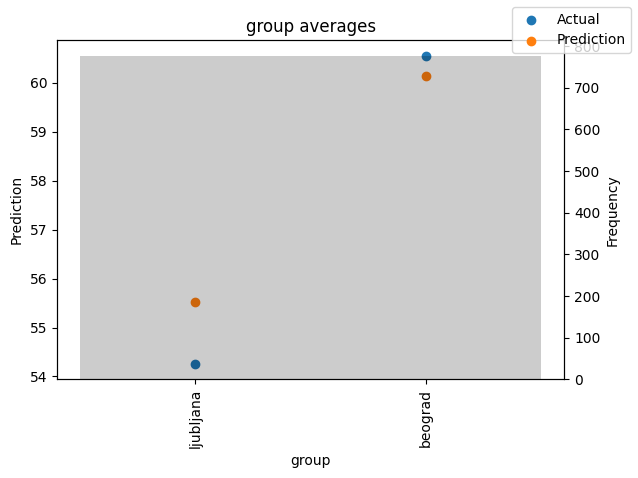

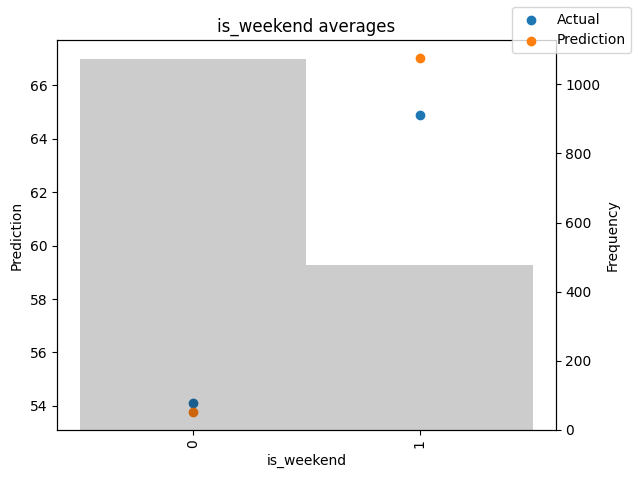

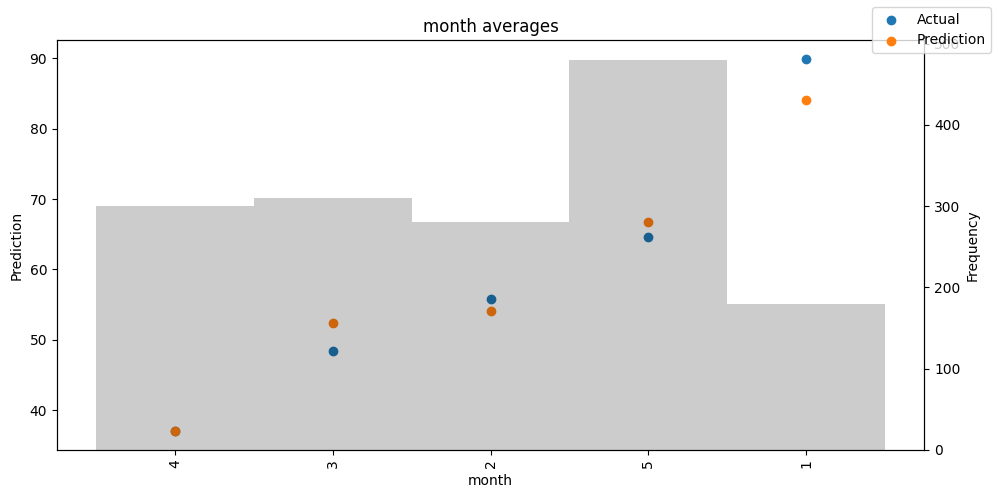

In [163]:
best_tft.plot_prediction_actual_by_variable(filtered_results)